In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def load_result(base_lr, mbs, bs, seeds=[1, 111, 11111], use_bn=False, adamSTD=False, kmax=None):
    if kmax:
        base_str = f"lr_{{}}__mbs_{{}}__bs_{{}}__kmax_{kmax}"
    else:
        base_str = 'lr_{}__mbs_{}__bs_{}'
    if use_bn:
        base_str += 'batchnorm__'
    base_str += 'dataAug__'
    if adamSTD:
        base_str += 'adamSTD__'
    name_template = './results/' + base_str + 'seed_{}___{}.npy'
    train_logs = []
    test_logs = []
    for seed in seeds:
        if os.path.exists(name_template.format(base_lr, mbs, bs, seed, 'train')):
            train_logs.append(np.load(name_template.format(base_lr, mbs, bs, seed, 'train')))
            test_logs.append(np.load(name_template.format(base_lr, mbs, bs, seed, 'test')))
    return np.stack(train_logs), np.stack(test_logs)

def load_result_vit(base_lr, mbs, bs, seeds=[1, 111, 11111], adamSTD=False, kmax=None):
    if kmax:
        base_str = f'ViTlr_{{}}__mbs_{{}}__bs_{{}}__kmax_{kmax}'
    else:
        base_str = 'ViTlr_{}__mbs_{}__bs_{}'
    
    base_str += 'dataAug__'
    if adamSTD:
        base_str += 'adamSTD__'
    name_template = './results/' + base_str + 'seed_{}___{}.npy'
    train_logs = []
    test_logs = []
    for seed in seeds:
        if os.path.exists(name_template.format(base_lr, mbs, bs, seed, 'train')):
            train_logs.append(np.load(name_template.format(base_lr, mbs, bs, seed, 'train')))
            test_logs.append(np.load(name_template.format(base_lr, mbs, bs, seed, 'test')))
    return np.stack(train_logs), np.stack(test_logs)

In [3]:
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
bs_list = [25, 50, 100, 200, 400, 800]
# bs_list = [25, 100, 200, 400, 800]

In [4]:
for i, lr in enumerate(lrs):
    for bs in bs_list:
        seed = 111
        name_template = './results/lr_{}__mbs_{}__bs_{}batchnorm__dataAug__seed_{}___{}.npy'
        if not os.path.isfile(name_template.format(lr, 25, bs, seed, 'train')):
            print(bs, lr)

50 1.0


# New plot, threshold v.s. number of steps

In [100]:
def find_min_step_required(t, x):
    bs = x[:, 0]
    l = x[:, 1:]
    target_step = np.argmin(l < t, -1) * (50000 // (bs))
    return target_step[target_step > 0].min()

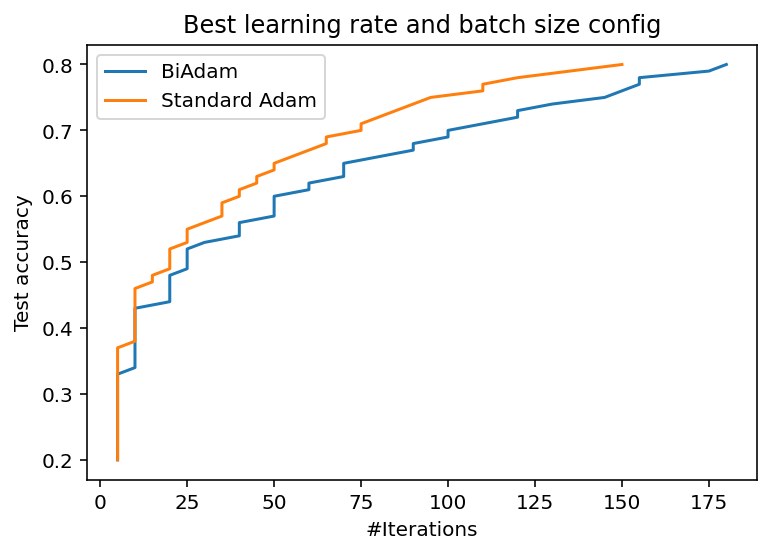

In [120]:
bs_list = [1000, 2000, 5000, 10000]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
thresholds = np.arange(0.2, 0.8, 0.01)

# thresholds = np.arange(0.6, 2.0, 0.01)

logs = []

for i, lr in enumerate(lrs_list):
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=False, kmax=1)
        R = R[1].mean(0)[:, 0]
        R = np.concatenate([np.array([bs]), R])
        logs.append(R)
logs = np.array(logs)

steps = []
for t in thresholds:
    steps.append(find_min_step_required(t, logs))
plt.plot(steps, thresholds, label='BiAdam')

logs = []
for i, lr in enumerate(lrs_list):
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=True, kmax=1)
        R = R[1].mean(0)[:, 0]
        R = np.concatenate([np.array([bs]), R])
        logs.append(R)
logs = np.array(logs)

steps = []
for t in thresholds:
    steps.append(find_min_step_required(t, logs))
plt.plot(steps, thresholds, label='Standard Adam')

plt.xlabel('#Iterations')
plt.ylabel('Test accuracy')
plt.title('Best learning rate and batch size config')
plt.legend()

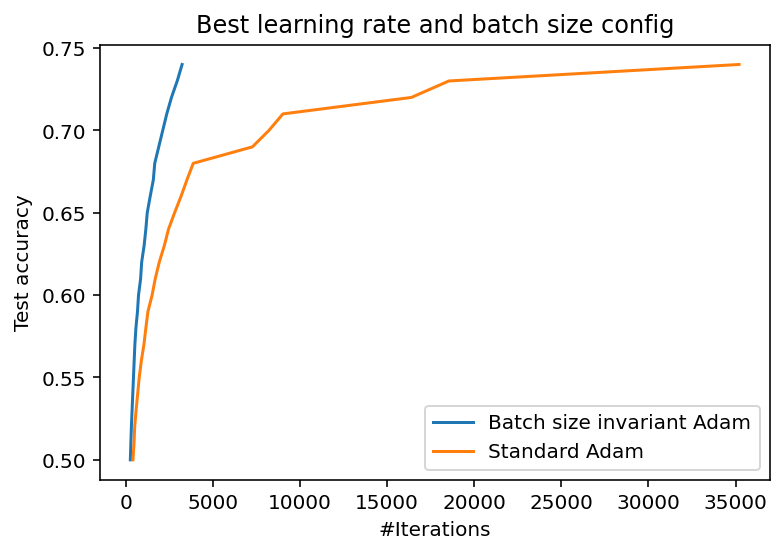

In [119]:
thresholds = np.arange(0.5, 0.75, 0.01)
bs_list = [500, 1000, 2000, 5000]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3][:-2]

logs = []

for i, lr in enumerate(lrs_list):
    for j, bs in enumerate(bs_list):
        R = load_result_vit(lr, 500, bs, seeds=[1, 111, 11111], adamSTD=False, kmax=1)
        R = R[1].mean(0)[:, 0]
        R = np.concatenate([np.array([bs]), R])
        logs.append(R)
logs = np.array(logs)

steps = []
for t in thresholds:
    steps.append(find_min_step_required(t, logs))
plt.plot(steps, thresholds, label='Batch size invariant Adam')

logs = []
for i, lr in enumerate(lrs_list):
    for j, bs in enumerate(bs_list):
        R = load_result_vit(lr, 500, bs, seeds=[1, 111, 11111], adamSTD=True, kmax=1)
        R = R[1].mean(0)[:, 0]
        R = np.concatenate([np.array([bs]), R])
        logs.append(R)
logs = np.array(logs)

steps = []
for t in thresholds:
    steps.append(find_min_step_required(t, logs))
plt.plot(steps, thresholds, label='Standard Adam')
plt.xlabel('#Iterations')
plt.ylabel('Test accuracy')
plt.title('Best learning rate and batch size config')
plt.legend()

# ViT

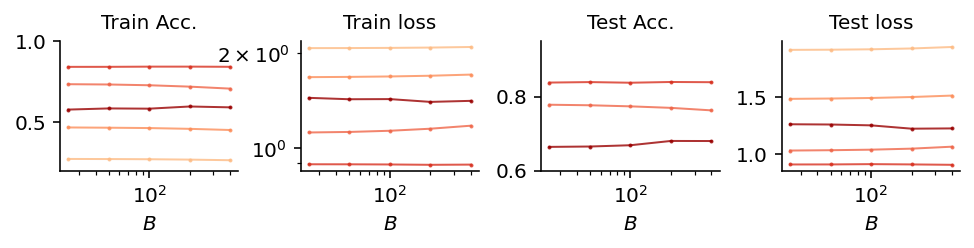

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -350
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list[:-1]:
        R = load_result_vit(lr, 25, bs, seeds=[1,  111, 11111], adamSTD=True)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for j in range(4):
        ax[j].plot(bs_list[:-1], metrics[:, j], label='$\\eta = 10^{{{}}}$'.format(int(np.log10(lr))),
                   c=colors[i], linewidth=1.0, alpha=0.8, marker='o', markersize=1.0)
ax[1].set_yscale('log')
ax[0].set_ylim(0.2, 1.0)
ax[2].set_ylim(0.6, 0.95)
# ax[3].set_ylim(0.4, 0.88)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel(r'$B$')
    # a.set_xticks([20, 100, 1000])
# fig.savefig('./figs/std_adam_batch_norm_vs_B.pdf', bbox_inches='tight')

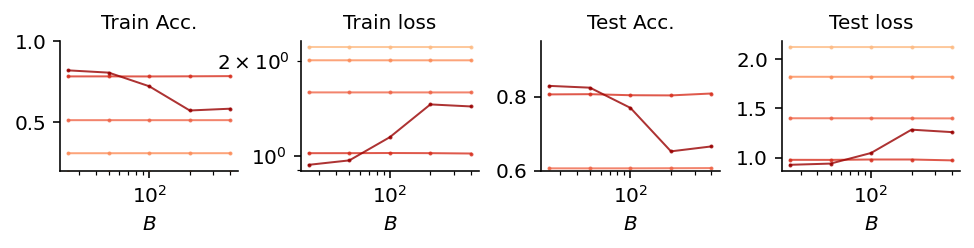

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -350
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list[:-1]:
        R = load_result_vit(lr, 25, bs, seeds=[1,  111, 11111], adamSTD=False)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for j in range(4):
        ax[j].plot(bs_list[:-1], metrics[:, j], label='$\\eta = 10^{{{}}}$'.format(int(np.log10(lr))),
                   c=colors[i], linewidth=1.0, alpha=0.8, marker='o', markersize=1.0)
ax[1].set_yscale('log')
ax[0].set_ylim(0.2, 1.0)
# ax[2].set_ylim(0.8, 0.95)
# ax[3].set_ylim(0.4, 0.88)
ax[2].set_ylim(0.6, 0.95)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel(r'$B$')
    # a.set_xticks([20, 100, 1000])
# fig.savefig('./figs/std_adam_batch_norm_vs_B.pdf', bbox_inches='tight')

(0.0, 100.0)

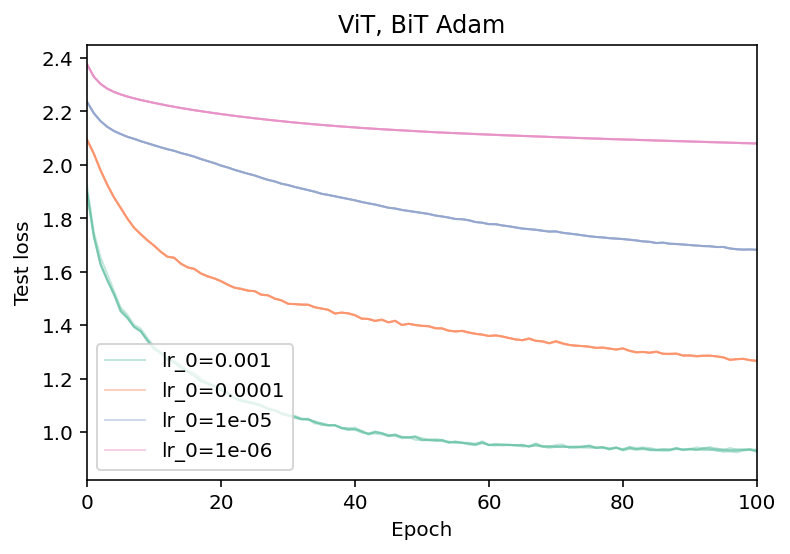

In [34]:
colors = plt.get_cmap('Set2')
for i, lr in enumerate(lrs[:4][::-1]):
    metrics = []
    for j, bs in enumerate(bs_list[:-1]):
        R = load_result_vit(lr, 25, bs, seeds=[1, 111, 11111], adamSTD=False)
        X = np.arange(400)
        plt.plot(X, R[1][:,:400, 1].mean((0,)), c=colors([i]),linewidth=1.0, alpha=0.4, label=f'lr_0={lr}' if not j else '')
    # metrics = np.array(metrics)
    # X = np.arange(200)
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.title('ViT, BiT Adam')
plt.legend()
plt.xlim(0, 100)

(0.0, 100.0)

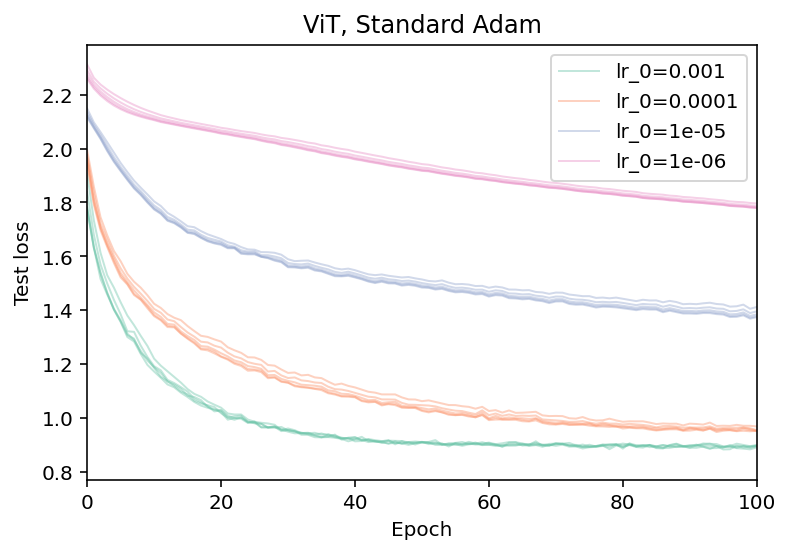

In [33]:
colors = plt.get_cmap('Set2')
for i, lr in enumerate(lrs[:4][::-1]):
    metrics = []
    for j, bs in enumerate(bs_list[:-1]):
        R = load_result_vit(lr, 25, bs, seeds=[1, 111, 11111], adamSTD=True)
        X = np.arange(400)
        plt.plot(X, R[1][:,:400, 1].mean((0,)), c=colors([i]),linewidth=1.0, alpha=0.4, label=f'lr_0={lr}' if not j else '')
    # metrics = np.array(metrics)
    # X = np.arange(200)
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Test loss')
plt.xlabel('Epoch')
plt.title('ViT, Standard Adam')
plt.legend()
plt.xlim(0, 100)

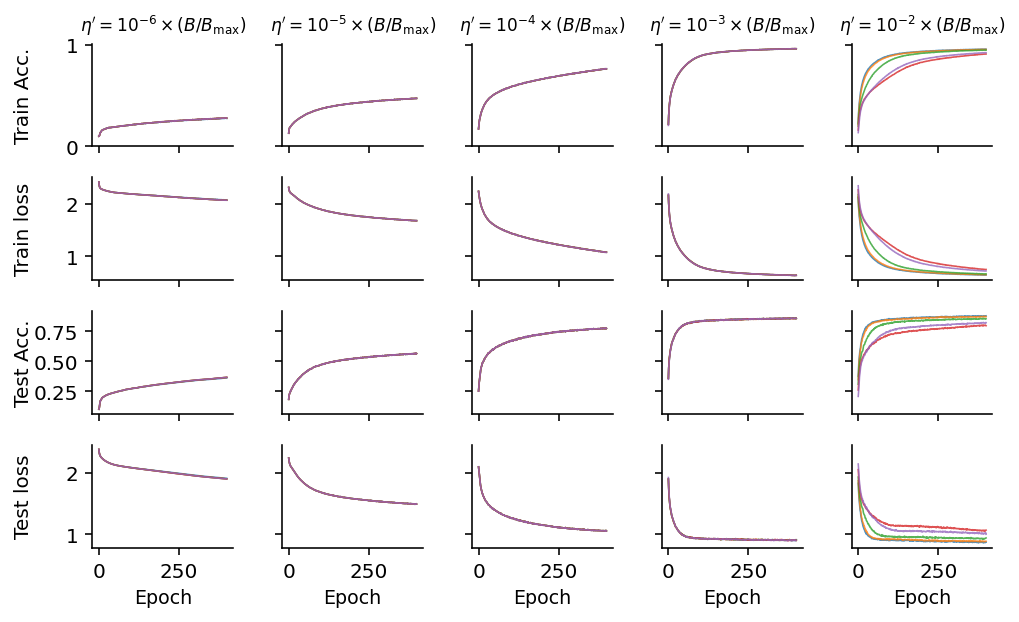

In [16]:
fig, ax = plt.subplots(4, 5, figsize=(6.25, 3.5), sharex='col', sharey='row')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, hspace=0.3, left=left, right=right, bottom=bottom, top=top)
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# lrs_list = [1e-6, 1e-5, 1e-4, 1e-3]
# lrs_list = [1e-6, 1e-5, 1e-3, 1e-1]
for i, lr in enumerate(lrs_list):
    for bs in bs_list[:-1]:
        R = load_result_vit(lr, 25, bs, seeds=[1, 111, 11111], adamSTD=False)
        ax[0, i].plot(R[0][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[1, i].plot(R[0][..., 1].mean(0), alpha=0.8, linewidth=0.8)
        ax[2, i].plot(R[1][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[3, i].plot(R[1][..., 1].mean(0), alpha=0.8, linewidth=0.8, label=f'$B=$ {bs}',)
    title_str = '$\\eta^\\prime = 10^{{{}}} \\times (B/B_{{\\rm max}})$'.format(int(np.log10(lr)))
    ax[0, i].set_title(title_str, fontsize=8.5)
    ax[-1, i].set_xlabel("Epoch", fontsize=9.5)

LABEL_SIZE = 10
ax[0, 0].set_ylabel("Train Acc.", fontsize=LABEL_SIZE)
ax[1, 0].set_ylabel("Train loss", fontsize=LABEL_SIZE)
ax[2, 0].set_ylabel("Test Acc.", fontsize=LABEL_SIZE)
ax[3, 0].set_ylabel("Test loss", fontsize=LABEL_SIZE)
ax[0, 0].set_ylim(0.0, 1.01)
# ax[0, 0].set_yscale('log')
# ax[1, 0].set_yscale('log')
# ax[3, 0].set_ylim(top=2.0)
# ax[2, 0].set_ylim(0.3, 0.95)
for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
# ax[1, 0].set_ylim(top=10e2)
for j in range(4):
    ax[j, 0].yaxis.set_label_coords(-0.42, 0.5)

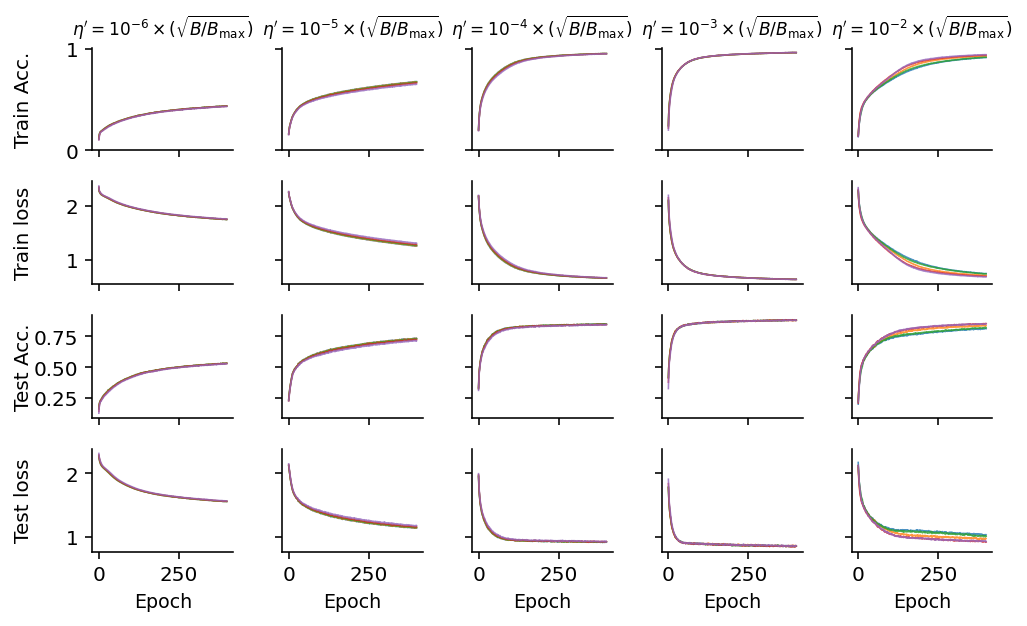

In [15]:
fig, ax = plt.subplots(4, 5, figsize=(6.25, 3.5), sharex='col', sharey='row')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, hspace=0.3, left=left, right=right, bottom=bottom, top=top)
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# lrs_list = [1e-6, 1e-5, 1e-4, 1e-3]
# lrs_list = [1e-6, 1e-5, 1e-3, 1e-1]
for i, lr in enumerate(lrs_list):
    for bs in bs_list[:-1]:
        R = load_result_vit(lr, 25, bs, seeds=[1, 111, 11111], adamSTD=True)
        ax[0, i].plot(R[0][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[1, i].plot(R[0][..., 1].mean(0), alpha=0.8, linewidth=0.8)
        ax[2, i].plot(R[1][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[3, i].plot(R[1][..., 1].mean(0), alpha=0.8, linewidth=0.8, label=f'$B=$ {bs}',)
    title_str = '$\\eta^\\prime = 10^{{{}}} \\times (\\sqrt{{B / B_{{\\rm max}} }})$'.format(int(np.log10(lr)))
    ax[0, i].set_title(title_str, fontsize=8.5)
    ax[-1, i].set_xlabel("Epoch", fontsize=9.5)

LABEL_SIZE = 10
ax[0, 0].set_ylabel("Train Acc.", fontsize=LABEL_SIZE)
ax[1, 0].set_ylabel("Train loss", fontsize=LABEL_SIZE)
ax[2, 0].set_ylabel("Test Acc.", fontsize=LABEL_SIZE)
ax[3, 0].set_ylabel("Test loss", fontsize=LABEL_SIZE)
ax[0, 0].set_ylim(0.0, 1.01)
# ax[0, 0].set_yscale('log')
# ax[1, 0].set_yscale('log')
# ax[3, 0].set_ylim(top=2.0)
# ax[2, 0].set_ylim(0.3, 0.95)
for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
# ax[1, 0].set_ylim(top=10e2)
for j in range(4):
    ax[j, 0].yaxis.set_label_coords(-0.42, 0.5)

# ResNet, LR v.s. relative error

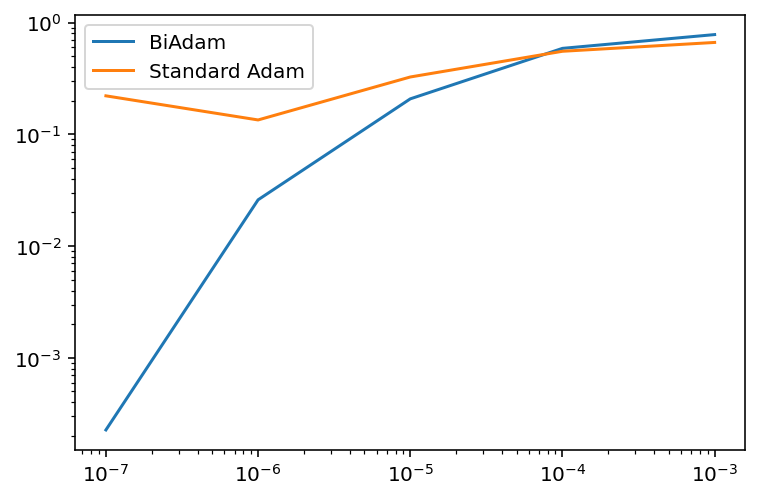

In [14]:
bs_list = [1000, 2000, 5000, 10000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0

N = 100
W = 2
metrics = []
for i, lr in enumerate(lrs_list):
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=False, kmax=1)
        metrics.append(R[1].mean(0)[N - W:N + W, 1].mean(0))
metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list))
relative_error = (metrics.max(-1) - metrics.min(-1)) 
plt.plot(lrs_list, relative_error, label='BiAdam')


metrics = []
for i, lr in enumerate(lrs_list):
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=True, kmax=1)
        metrics.append(R[1].mean(0)[N - W:N + W, 1].mean(0))
metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list))
relative_error = (metrics.max(-1) - metrics.min(-1)) 
plt.plot(lrs_list, relative_error, label='Standard Adam')
plt.legend()
plt.yscale('log')
plt.xscale('log')

In [51]:
def plot_mean_and_std(X, Y, ax, label, **kwargs):
    mean = Y.mean(0)
    std = Y.std(0)
    ax.plot(X, mean, label=label, **kwargs)
    ax.fill_between(X, mean - std, mean + std, alpha=0.4, **kwargs)

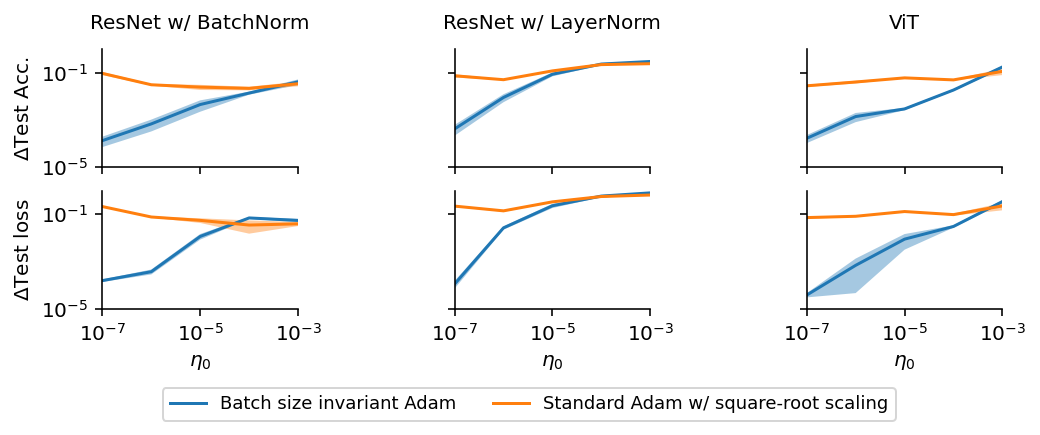

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(6.25, 1.8), sharey='row', sharex='col')

bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.8, left=left, right=right, bottom=bottom, top=top)


def compute_error(metrics):
    return (metrics.max(-1) - metrics.min(-1))

bs_list = [1000, 2000, 5000, 10000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0
N = 100
W = 1
for mid in range(2):
    # ResNet with BN
    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=False, kmax=1)
            metrics.append(R[1][:, N - W:N + W, mid].mean(1))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list), -1).transpose(2, 0, 1)
    relative_error = compute_error(metrics)
    plot_mean_and_std(lrs_list, relative_error, ax[mid, 0], 'Batch size invariant Adam')
    # plot_mean_and_std(lrs_list, relative_error, ax[mid, 0])
    # ax[mid, 0].plot(lrs_list, relative_error, label='Batch size invariant Adam')

    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=True, kmax=1)
            metrics.append(R[1][:, N - W:N + W, mid].mean(1))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list), -1).transpose(2, 0, 1)
    relative_error = compute_error(metrics)
    plot_mean_and_std(lrs_list, relative_error, ax[mid, 0], 'Standard Adam w/ square-root scaling')
    # ax[mid, 0].plot(lrs_list, relative_error.mean(0))
    # ax[mid, 0].plot(lrs_list, relative_error, label='Standard Adam w/ square-root scaling')
    
    # ResNet with LN
    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=False, kmax=1)
            metrics.append(R[1][:, N - W:N + W, mid].mean(1))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list), -1).transpose(2, 0, 1)
    relative_error = compute_error(metrics)
    plot_mean_and_std(lrs_list, relative_error, ax[mid, 1], 'Batch size invariant Adam')
    # ax[mid, 1].plot(lrs_list, relative_error, label='Batch size invariant Adam')

    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=True, kmax=1)
            metrics.append(R[1][:, N - W:N + W, mid].mean(1))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list), -1).transpose(2, 0, 1)
    relative_error = compute_error(metrics)
    plot_mean_and_std(lrs_list, relative_error, ax[mid, 1], 'Standard Adam w/ square-root scaling')
    # ax[mid, 1].plot(lrs_list, relative_error, label='Standard Adam w/ square-root scaling')
    
    # ViT
    metrics = []
    bs_list_vit = [500, 1000, 2000, 5000]
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list_vit):
            R = load_result_vit(lr, 500, bs, seeds=[1, 11, 111, 11111], adamSTD=False, kmax=1)
            metrics.append(R[1][:, N - W:N + W, mid].mean(1))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list), -1).transpose(2, 0, 1)
    relative_error = compute_error(metrics)
    plot_mean_and_std(lrs_list, relative_error, ax[mid, 2], 'Batch size invariant Adam')
    # ax[mid, 2].plot(lrs_list, relative_error, label='Batch size invariant Adam')

    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list_vit):
            R = load_result_vit(lr, 500, bs, seeds=[1, 11, 111, 11111], adamSTD=True, kmax=1)
            metrics.append(R[1][:, N - W:N + W, mid].mean(1))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list), -1).transpose(2, 0, 1)
    relative_error = compute_error(metrics)
    plot_mean_and_std(lrs_list, relative_error, ax[mid, 2], 'Standard Adam w/ square-root scaling')
    # ax[mid, 2].plot(lrs_list, relative_error, label='Standard Adam w/ square-root scaling')


for a in ax.flatten():
    a.set_xscale('log')
    a.set_yscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim(1e-7, 1e-3)
    a.set_ylim(1e-5, 1e0)

for a in ax[1, :]:
    a.set_xlabel(r'$\eta_0$', fontsize=10)
    a.set_xticks([1e-7, 1e-5, 1e-3])
    
    
ax[0, 0].set_title('ResNet w/ BatchNorm', fontsize=10, pad=10)
ax[0, 1].set_title('ResNet w/ LayerNorm', fontsize=10, pad=10)
ax[0, 2].set_title('ViT', fontsize=10, pad=10)
# ax[0, 3].set_title('400th epoch')

ax[0, 0].set_ylabel(r'$\Delta$' + 'Test Acc.')
ax[1, 0].set_ylabel(r'$\Delta$' + 'Test loss')
ax[0, 0].legend(ncol=2, bbox_to_anchor=(4.1, -1.8), fontsize=9.0)
fig.savefig('./figs/fig1.pdf', bbox_inches='tight')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')

Text(0, 0.5, '$\\Delta$Test Acc.')

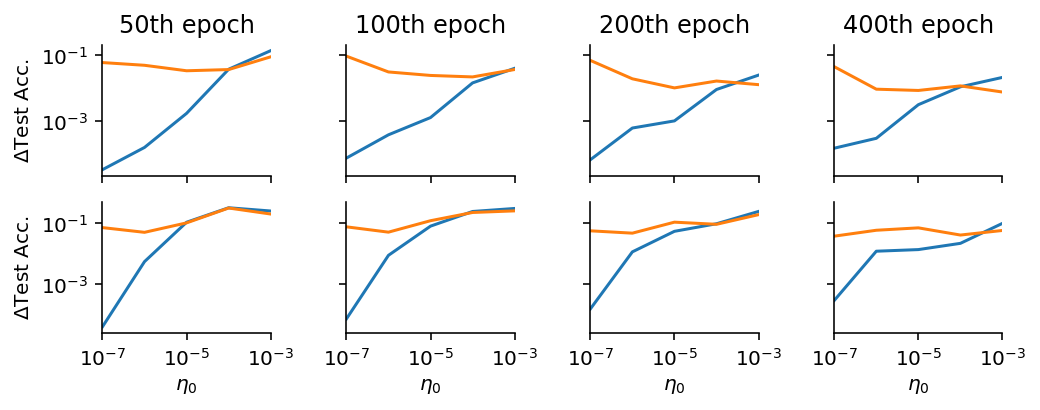

In [47]:
fig, ax = plt.subplots(2, 4, figsize=(6.25, 2.0), sharey='row', sharex='col')

bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.45, left=left, right=right, bottom=bottom, top=top)

bs_list = [1000, 2000, 5000, 10000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0
N = 350
W = 2


for cid, N in enumerate([50, 100, 200, 400]):
    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=False, kmax=1)
            metrics.append(R[1].mean(0)[N - W:N + W, 0].mean(0))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list))
    relative_error = (metrics.max(-1) - metrics.min(-1)) 
    ax[0, cid].plot(lrs_list, relative_error, label='BiAdam')
    plot_mean_and_std(lrs_list, relative_error,)


    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=True, kmax=1)
            metrics.append(R[1].mean(0)[N - W:N + W, 0].mean(0))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list))
    relative_error = (metrics.max(-1) - metrics.min(-1))
    ax[0, cid].plot(lrs_list, relative_error, label='Standard Adam')
    
    
for cid, N in enumerate([50, 100, 200, 400]):
    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=False, kmax=1)
            metrics.append(R[1].mean(0)[N - W:N + W, 0].mean(0))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list))
    relative_error = (metrics.max(-1) - metrics.min(-1)) 
    ax[1, cid].plot(lrs_list, relative_error, label='BiAdam')


    metrics = []
    for i, lr in enumerate(lrs_list):
        for j, bs in enumerate(bs_list):
            R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=True, kmax=1)
            metrics.append(R[1].mean(0)[N - W:N + W, 0].mean(0))
    metrics = np.array(metrics).reshape(len(lrs_list), len(bs_list))
    relative_error = (metrics.max(-1) - metrics.min(-1))
    ax[1, cid].plot(lrs_list, relative_error, label='Standard Adam')


for a in ax.flatten():
    a.set_xscale('log')
    a.set_yscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xticks([1e-7, 1e-5, 1e-3])
    a.set_xlim(1e-7, 1e-3)

for a in ax[1, :]:
    a.set_xlabel(r'$\eta_0$')
    
ax[0, 0].set_title('50th epoch')
ax[0, 1].set_title('100th epoch')
ax[0, 2].set_title('200th epoch')
ax[0, 3].set_title('400th epoch')

ax[0, 0].set_ylabel(r'$\Delta$' + 'Test Acc.')
ax[1, 0].set_ylabel(r'$\Delta$' + 'Test Acc.')
# plt.legend()
# plt.yscale('log')
# plt.xscale('log')

# ResNet

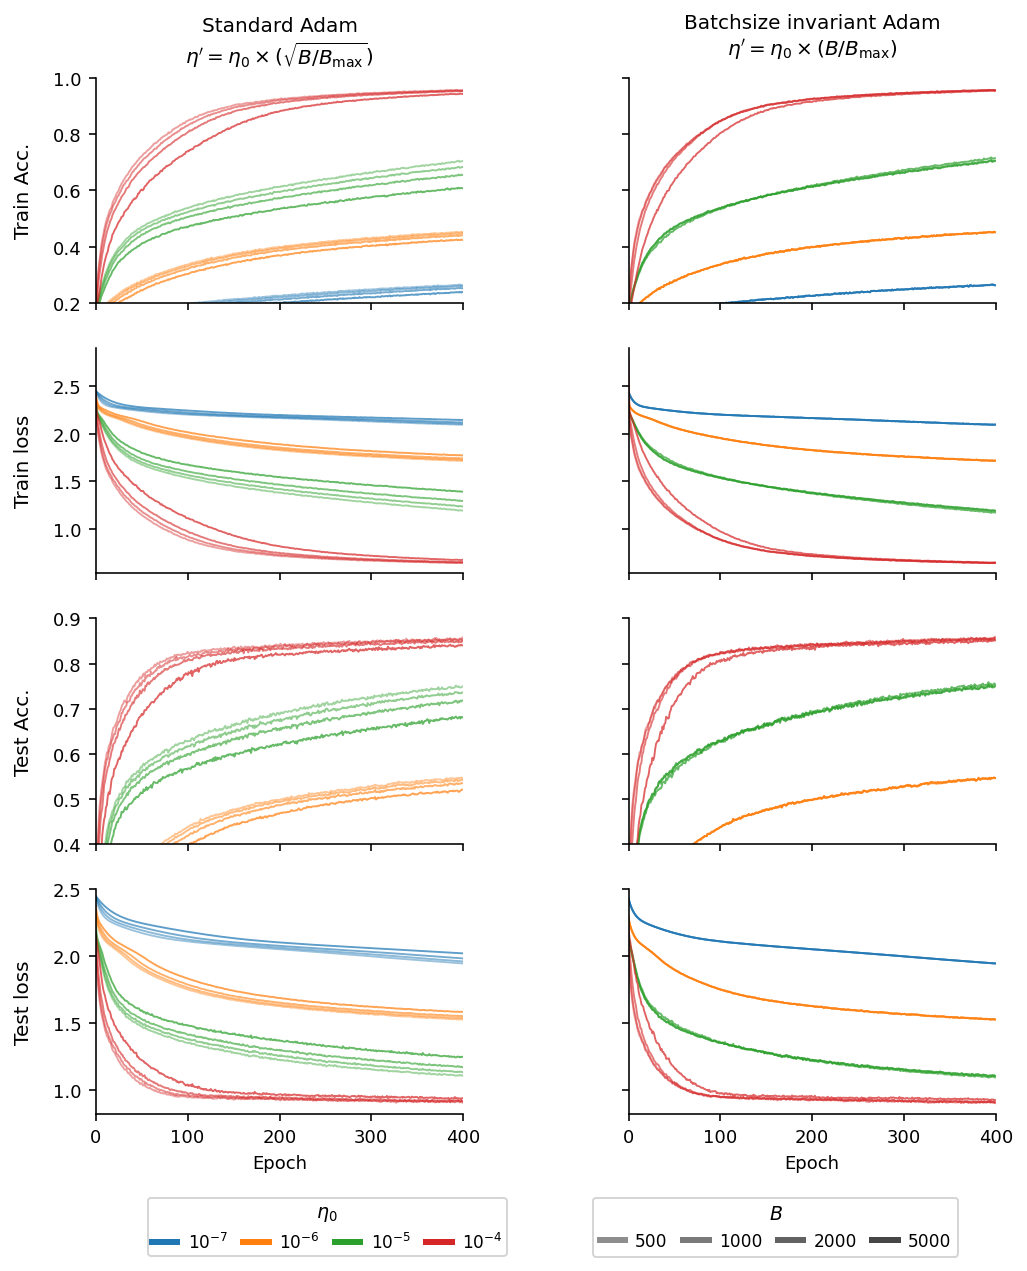

In [57]:
fig, ax = plt.subplots(4, 2, figsize=(6.25, 7.2), sharey='row', sharex='col')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.45, left=left, right=right, bottom=bottom, top=top)
# bs_list = [25, 50, 100,200, 400]
bs_list = [500, 1000, 2000, 5000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(20)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2][:-2]
alphas = [0.85 ** i for i in range(6)][::-1]

for i, lr in enumerate(lrs_list):
    metrics = []
    for j, bs in enumerate(bs_list):
        # R = load_result_vit(lr, 25, bs, seeds=[1, 111, 11111], adamSTD=True, kmax=16)
        R = load_result_vit(lr, 500, bs, seeds=[1, 111, 11111], adamSTD=True, kmax=1)
        X = np.arange(400)
        c=colors[i]
        alpha=alphas[j]
        ax[0, 0].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        ax[1, 0].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        ax[2, 0].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        ax[3, 0].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        # R = load_result_vit(lr, 25, bs, seeds=[1, 111, 11111], adamSTD=False, kmax=16)
        R = load_result_vit(lr, 500, bs, seeds=[1, 111, 11111], adamSTD=False, kmax=1)
        ax[0, 1].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        ax[1, 1].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        ax[2, 1].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=0.95, alpha=alpha)
        ax[3, 1].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=0.95, alpha=alpha)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim(0, 400)
    # a.set_xlim(0, 5)
    a.tick_params(axis='both', labelsize=9)
# ax[1, 0].set_yscale('log')
title_font_size = 10
ax[1, 0].set_ylabel('Train loss', fontsize=title_font_size)
ax[3, 0].set_ylabel('Test loss', fontsize=title_font_size)
ax[1, 0].yaxis.set_label_coords(-0.25, 0.5)


ax[2, 0].set_ylim(0.4, 0.9)
ax[0, 0].set_ylim(0.2, 1.0)
ax[3, 0].set_ylim(0.82, 2.5 )
ax[0, 0].set_ylabel('Train Acc.', fontsize=title_font_size)
ax[2, 0].set_ylabel('Test Acc.', fontsize=title_font_size)
ax[0, 0].yaxis.set_label_coords(-0.15, 0.5)
ax[1, 0].yaxis.set_label_coords(-0.15, 0.5)
for a in ax[-1]:
    a.set_xlabel("Epoch", fontsize=9)

ax[0, 0].set_title('Standard Adam\n' + r'$\eta^\prime = \eta_0 \times (\sqrt{B / B_{\rm max} })$', y=1.01, fontsize=title_font_size)
ax[0, 1].set_title('Batchsize invariant Adam\n' + r'$\eta^\prime = \eta_0 \times ({B / B_{\rm max} })$', y=1.05, fontsize=title_font_size)


for a in ax[:, 0]:
    a.yaxis.set_label_coords(-0.17, 0.5)

# Make some legends
lines_etas = []
lines_bs = []
for i, lr in enumerate(lrs_list):
    line_etas, = ax[-1, -1].plot([0], c=colors[i],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label='$10^{{{}}}$'.format(int(np.log10(lr)))
                   )
    lines_etas.append(line_etas)
for j, bs in enumerate(bs_list):
    line_bs, = ax[-1, -1].plot([0],  c='black', alpha=alphas[j],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label=str(bs)
                   )
    lines_bs.append(line_bs)
    
# eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=1, title="$\eta_0$", bbox_to_anchor=(1.5, 1.8), fontsize=11, title_fontsize=11)
# bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=1, title="$B$", bbox_to_anchor=(1.9, 1.8), fontsize=11, handletextpad=1.3, title_fontsize=11)
legend_font_size = 8.5
eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=4, title="$\eta_0$", bbox_to_anchor=(-0.82, -0.5),
                                 fontsize=legend_font_size, title_fontsize=legend_font_size + 1, loc=10,
                                 handletextpad=0.6, columnspacing=0.9, handlelength=1.5, borderpad=0.25)
bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=5, title="$B$", bbox_to_anchor=(0.4, -0.5),
                              fontsize=legend_font_size,  title_fontsize=legend_font_size + 1,
                              handletextpad=0.6, loc=10,  columnspacing=0.9, handlelength=1.5)
ax[-1, -1].add_artist(eta_0_legend)

# fig.savefig('./figs/train_metrics_vit.pdf', bbox_inches='tight')
# fig.savefig('./figs/test_metrics_vit.pdf', bbox_inches='tight')
fig.savefig('./figs/metrics_vit.pdf', bbox_inches='tight')

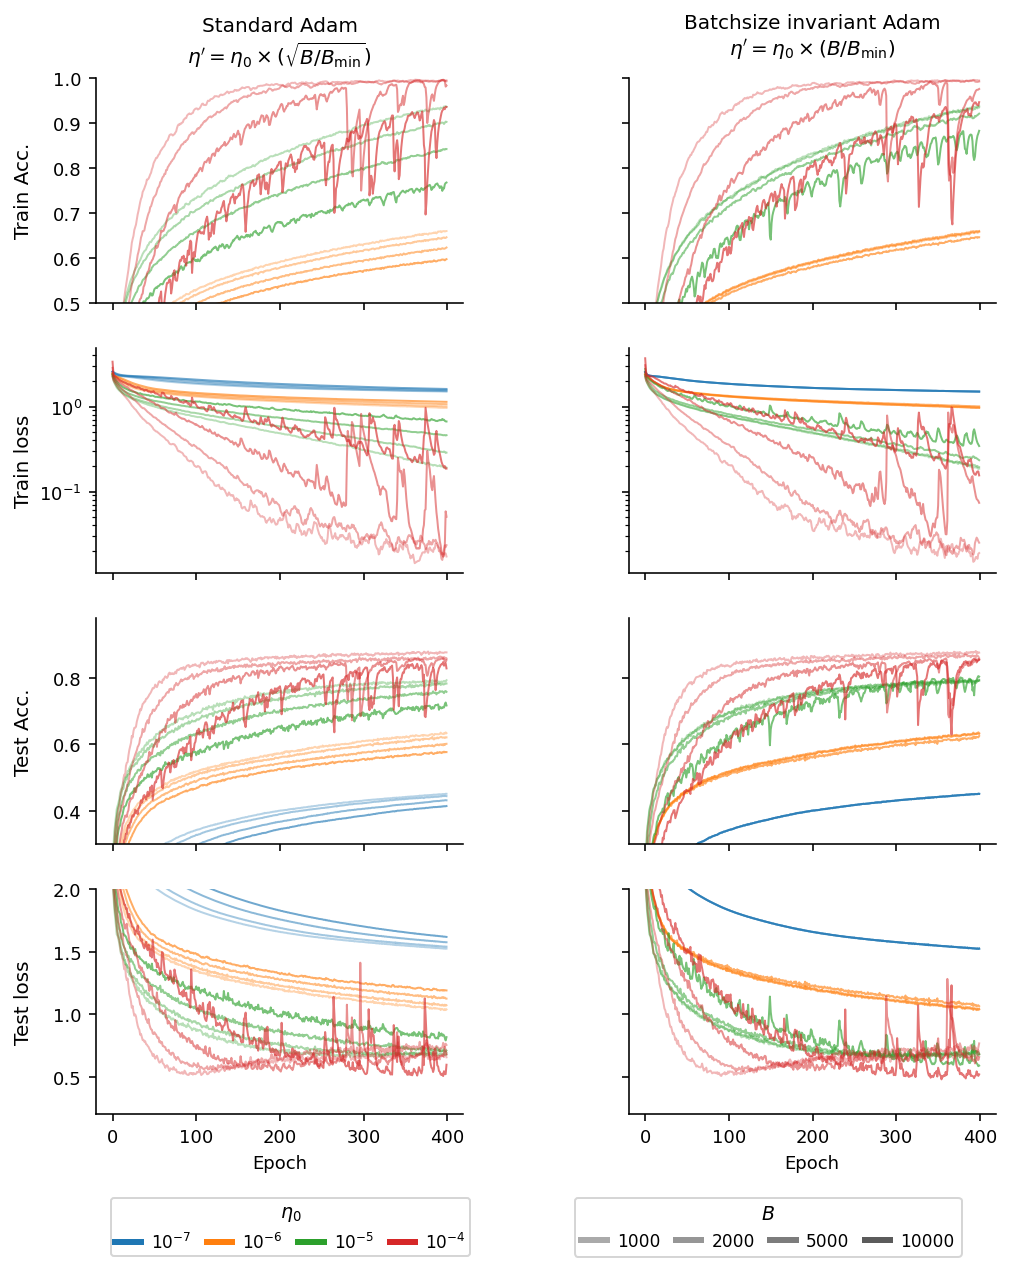

In [6]:
fig, ax = plt.subplots(4, 2, figsize=(6.25, 7.2), sharey='row', sharex='col')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.45, left=left, right=right, bottom=bottom, top=top)
bs_list = [1000, 2000, 5000, 10000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3][:-1]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0
for i, lr in enumerate(lrs_list):
    metrics = []
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=True, kmax=1)
        X = np.arange(400)
        c=colors[i]
        alpha=alphas[j]
        ax[0, 0].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 0].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 0].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 0].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=False, kmax=1)
        ax[0, 1].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 1].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 1].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 1].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.set_xlim(0, 200)
    a.tick_params(axis='both', labelsize=9)
title_font_size = 10
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Train loss', fontsize=title_font_size)
ax[3, 0].set_ylabel('Test loss', fontsize=title_font_size)


ax[0, 0].set_ylim(0.5, 1.0)
ax[2, 0].set_ylim(0.3, 0.98)
ax[3, 0].set_ylim(0.2, 2.0)
ax[1, 0].set_yscale('log')
ax[0, 0].set_ylabel('Train Acc.', fontsize=title_font_size)
ax[2, 0].set_ylabel('Test Acc.', fontsize=title_font_size)


for a in ax[:, 0]:
    a.yaxis.set_label_coords(-0.17, 0.5)

for a in ax[-1]:
    a.set_xlabel("Epoch", fontsize=9)

ax[0, 0].set_title('Standard Adam\n' + r'$\eta^\prime = \eta_0 \times (\sqrt{B / B_{\rm min} })$', y=1.01, fontsize=title_font_size)
ax[0, 1].set_title('Batchsize invariant Adam\n' + r'$\eta^\prime = \eta_0 \times ({B / B_{\rm min} })$', y=1.05, fontsize=title_font_size)


lines_etas = []
lines_bs = []
for i, lr in enumerate(lrs_list):
    line_etas, = ax[-1, -1].plot([0], c=colors[i],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label='$10^{{{}}}$'.format(int(np.log10(lr)))
                   )
    lines_etas.append(line_etas)
for j, bs in enumerate(bs_list):
    line_bs, = ax[-1, -1].plot([0],  c='black', alpha=alphas[j],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label=str(bs)
                   )
    lines_bs.append(line_bs)
# eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=1, title="$\eta_0$", bbox_to_anchor=(1.5, 1.8), fontsize=11, title_fontsize=11)
# bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=1, title="$B$", bbox_to_anchor=(1.9, 1.8), fontsize=11, handletextpad=1.3, title_fontsize=11)
legend_font_size = 8.5
eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=4, title="$\eta_0$", bbox_to_anchor=(-0.92, -0.5),
                                 fontsize=legend_font_size, title_fontsize=legend_font_size + 1, loc=10,
                                 handletextpad=0.6, columnspacing=0.9, handlelength=1.5, borderpad=0.25)
bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=6, title="$B$", bbox_to_anchor=(0.38, -0.5),
                              fontsize=legend_font_size,  title_fontsize=legend_font_size + 1,
                              handletextpad=0.6, loc=10,  columnspacing=0.9, handlelength=1.5)
ax[-1, -1].add_artist(eta_0_legend)

# fig.savefig('./figs/train_metrics_resnet_bn.pdf', bbox_inches='tight')
# fig.savefig('./figs/test_metrics_resnet_bn.pdf', bbox_inches='tight')
fig.savefig('./figs/metrics_resnet_ln.pdf', bbox_inches='tight')

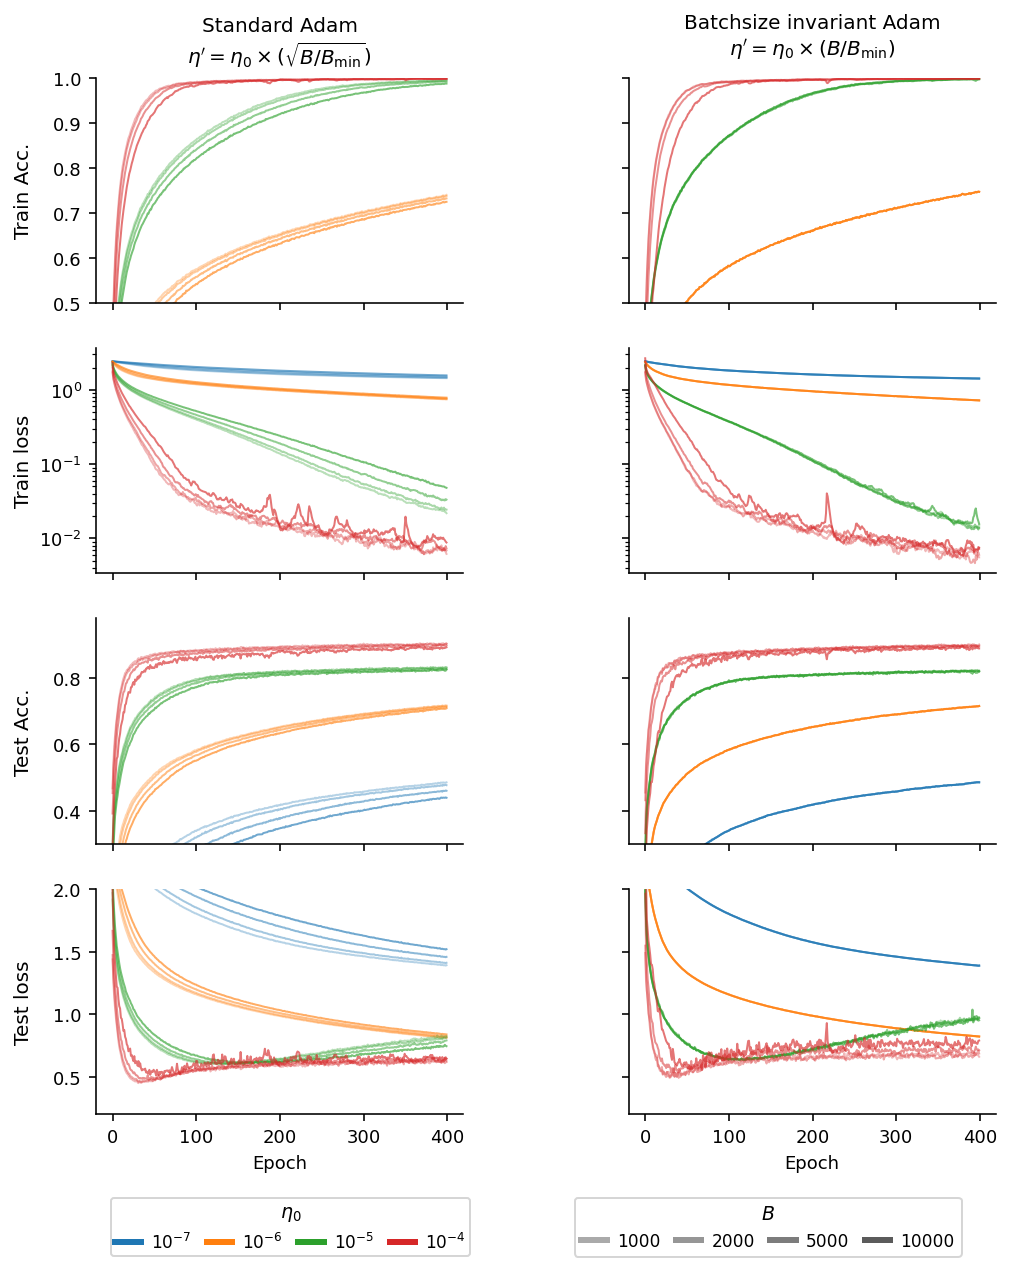

In [7]:
fig, ax = plt.subplots(4, 2, figsize=(6.25, 7.2), sharey='row', sharex='col')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.45, left=left, right=right, bottom=bottom, top=top)
bs_list = [1000, 2000, 5000, 10000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3][:-1]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0
for i, lr in enumerate(lrs_list):
    metrics = []
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=True, kmax=1)
        X = np.arange(400)
        c=colors[i]
        alpha=alphas[j]
        ax[0, 0].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 0].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 0].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 0].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=True, adamSTD=False, kmax=1)
        ax[0, 1].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 1].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 1].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 1].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.set_xlim(0, 200)
    a.tick_params(axis='both', labelsize=9)
title_font_size = 10
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Train loss', fontsize=title_font_size)
ax[3, 0].set_ylabel('Test loss', fontsize=title_font_size)


ax[0, 0].set_ylim(0.5, 1.0)
ax[2, 0].set_ylim(0.3, 0.98)
ax[3, 0].set_ylim(0.2, 2.0)
ax[1, 0].set_yscale('log')
ax[0, 0].set_ylabel('Train Acc.', fontsize=title_font_size)
ax[2, 0].set_ylabel('Test Acc.', fontsize=title_font_size)


for a in ax[:, 0]:
    a.yaxis.set_label_coords(-0.17, 0.5)

for a in ax[-1]:
    a.set_xlabel("Epoch", fontsize=9)

ax[0, 0].set_title('Standard Adam\n' + r'$\eta^\prime = \eta_0 \times (\sqrt{B / B_{\rm min} })$', y=1.01, fontsize=title_font_size)
ax[0, 1].set_title('Batchsize invariant Adam\n' + r'$\eta^\prime = \eta_0 \times ({B / B_{\rm min} })$', y=1.05, fontsize=title_font_size)


lines_etas = []
lines_bs = []
for i, lr in enumerate(lrs_list):
    line_etas, = ax[-1, -1].plot([0], c=colors[i],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label='$10^{{{}}}$'.format(int(np.log10(lr)))
                   )
    lines_etas.append(line_etas)
for j, bs in enumerate(bs_list):
    line_bs, = ax[-1, -1].plot([0],  c='black', alpha=alphas[j],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label=str(bs)
                   )
    lines_bs.append(line_bs)
# eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=1, title="$\eta_0$", bbox_to_anchor=(1.5, 1.8), fontsize=11, title_fontsize=11)
# bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=1, title="$B$", bbox_to_anchor=(1.9, 1.8), fontsize=11, handletextpad=1.3, title_fontsize=11)
legend_font_size = 8.5
eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=4, title="$\eta_0$", bbox_to_anchor=(-0.92, -0.5),
                                 fontsize=legend_font_size, title_fontsize=legend_font_size + 1, loc=10,
                                 handletextpad=0.6, columnspacing=0.9, handlelength=1.5, borderpad=0.25)
bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=6, title="$B$", bbox_to_anchor=(0.38, -0.5),
                              fontsize=legend_font_size,  title_fontsize=legend_font_size + 1,
                              handletextpad=0.6, loc=10,  columnspacing=0.9, handlelength=1.5)
ax[-1, -1].add_artist(eta_0_legend)

# fig.savefig('./figs/train_metrics_resnet_bn.pdf', bbox_inches='tight')
# fig.savefig('./figs/test_metrics_resnet_bn.pdf', bbox_inches='tight')
fig.savefig('./figs/metrics_resnet_bn.pdf', bbox_inches='tight')

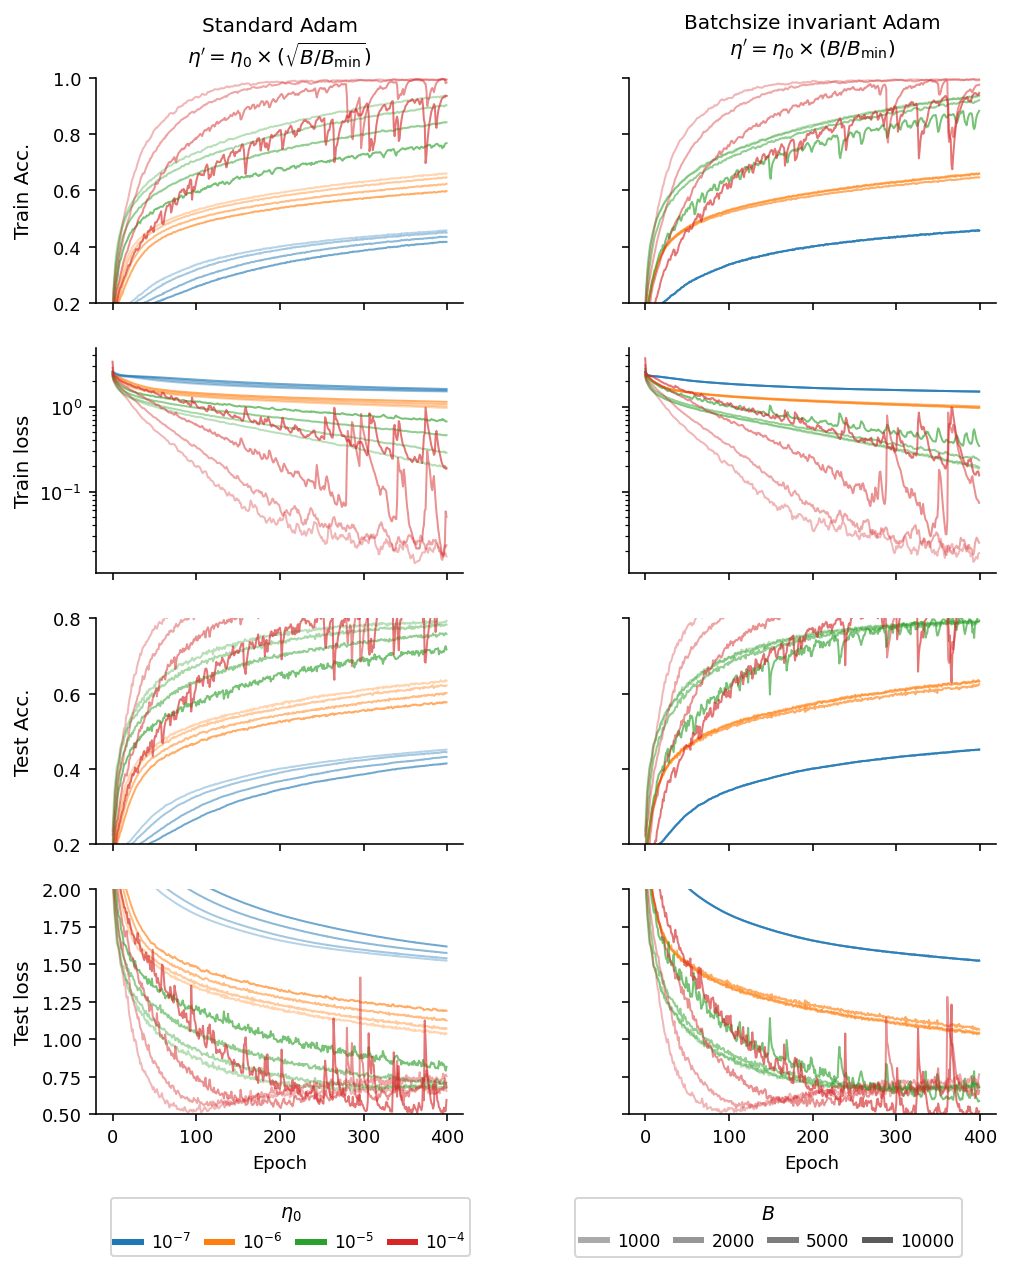

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(6.25, 7.2), sharey='row', sharex='col')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.45, left=left, right=right, bottom=bottom, top=top)
bs_list = [1000, 2000, 5000, 10000]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3]
lrs_list = [1e-7, 1e-6, 1e-5, 1e-4]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0
for i, lr in enumerate(lrs_list):
    metrics = []
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=True, kmax=1)
        X = np.arange(400)
        c=colors[i]
        alpha=alphas[j]
        ax[0, 0].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 0].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 0].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 0].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        R = load_result(lr, 1000, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=False, kmax=1)
        ax[0, 1].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 1].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 1].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 1].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.set_xlim(0, 200)
    a.tick_params(axis='both', labelsize=9)
title_font_size = 10
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Train loss', fontsize=title_font_size)
ax[3, 0].set_ylabel('Test loss', fontsize=title_font_size)


ax[0, 0].set_ylim(0.2, 1.0)
ax[2, 0].set_ylim(0.2, 0.8)
ax[3, 0].set_ylim(0.5, 2.0)
ax[1, 0].set_yscale('log')
ax[0, 0].set_ylabel('Train Acc.', fontsize=title_font_size)
ax[2, 0].set_ylabel('Test Acc.', fontsize=title_font_size)


for a in ax[:, 0]:
    a.yaxis.set_label_coords(-0.17, 0.5)

for a in ax[-1]:
    a.set_xlabel("Epoch", fontsize=9)

ax[0, 0].set_title('Standard Adam\n' + r'$\eta^\prime = \eta_0 \times (\sqrt{B / B_{\rm min} })$', y=1.01, fontsize=title_font_size)
ax[0, 1].set_title('Batchsize invariant Adam\n' + r'$\eta^\prime = \eta_0 \times ({B / B_{\rm min} })$', y=1.05, fontsize=title_font_size)


lines_etas = []
lines_bs = []
for i, lr in enumerate(lrs_list):
    line_etas, = ax[-1, -1].plot([0], c=colors[i],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label='$10^{{{}}}$'.format(int(np.log10(lr)))
                   )
    lines_etas.append(line_etas)
for j, bs in enumerate(bs_list):
    line_bs, = ax[-1, -1].plot([0],  c='black', alpha=alphas[j],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label=str(bs)
                   )
    lines_bs.append(line_bs)
# eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=1, title="$\eta_0$", bbox_to_anchor=(1.5, 1.8), fontsize=11, title_fontsize=11)
# bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=1, title="$B$", bbox_to_anchor=(1.9, 1.8), fontsize=11, handletextpad=1.3, title_fontsize=11)
legend_font_size = 8.5
eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=4, title="$\eta_0$", bbox_to_anchor=(-0.92, -0.5),
                                 fontsize=legend_font_size, title_fontsize=legend_font_size + 1, loc=10,
                                 handletextpad=0.6, columnspacing=0.9, handlelength=1.5, borderpad=0.25)
bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=6, title="$B$", bbox_to_anchor=(0.38, -0.5),
                              fontsize=legend_font_size,  title_fontsize=legend_font_size + 1,
                              handletextpad=0.6, loc=10,  columnspacing=0.9, handlelength=1.5)
ax[-1, -1].add_artist(eta_0_legend)

# fig.savefig('./figs/train_metrics_resnet_bn.pdf', bbox_inches='tight')
# fig.savefig('./figs/test_metrics_resnet_bn.pdf', bbox_inches='tight')
# fig.savefig('./figs/metrics_resnet_bn.pdf', bbox_inches='tight')

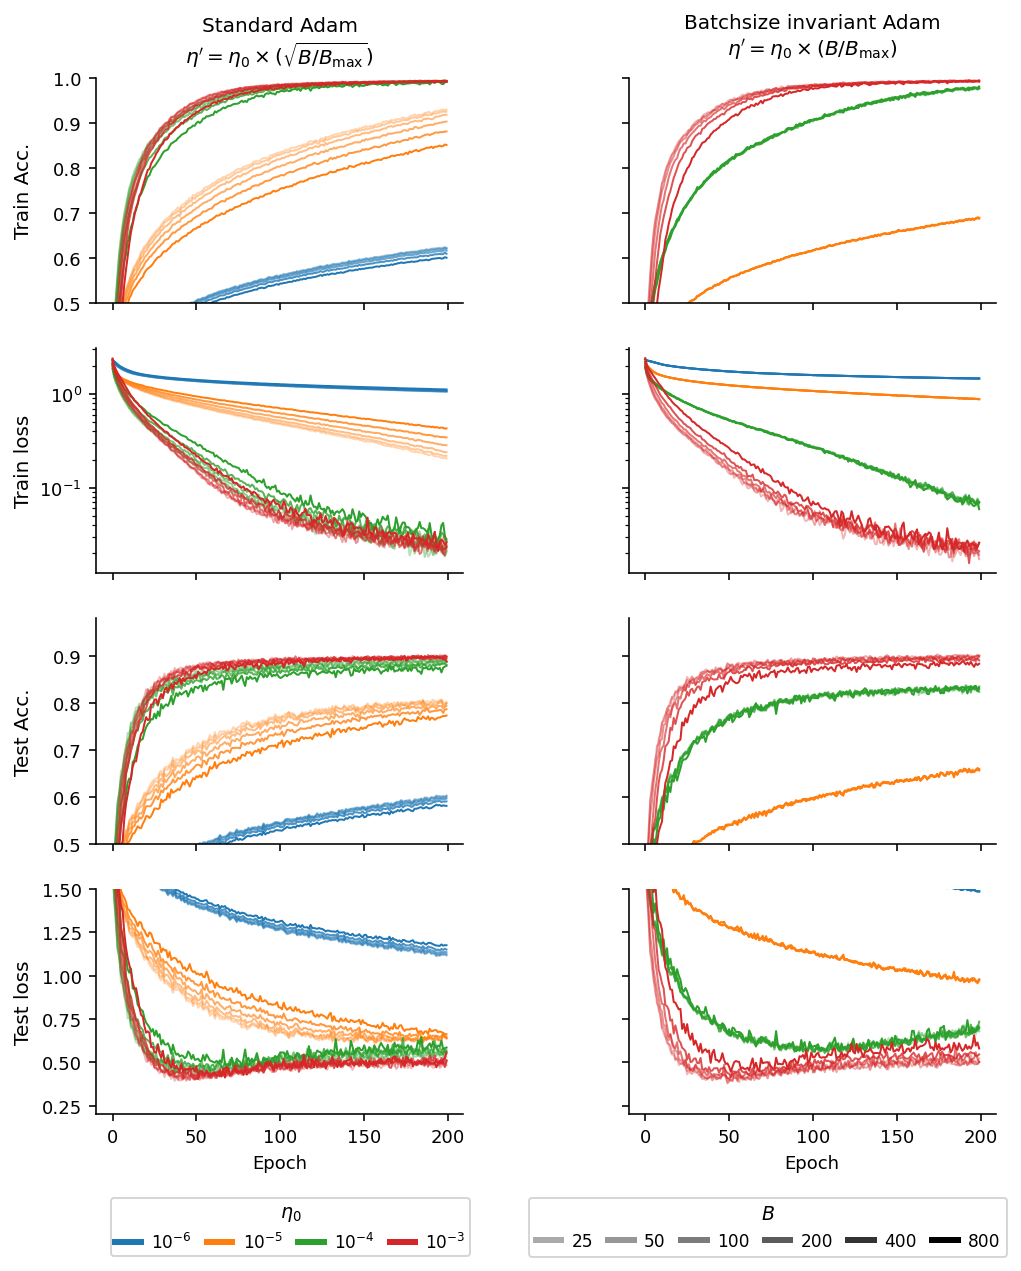

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(6.25, 7.2), sharey='row', sharex='col')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.45, left=left, right=right, bottom=bottom, top=top)
bs_list = [25, 50, 100,200, 400, 800]
colors = plt.get_cmap('tab10')
colors = [colors([i]) for i in range(10)]
# colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2][:-1]
alphas = [0.8 ** i for i in range(6)][::-1]
LW=1.0
for i, lr in enumerate(lrs_list):
    metrics = []
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 25, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=True, kmax=32)
        X = np.arange(200)
        c=colors[i]
        alpha=alphas[j]
        ax[0, 0].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 0].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 0].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 0].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        R = load_result(lr, 25, bs, seeds=[1, 11, 111, 11111], use_bn=False, adamSTD=False, kmax=32)
        ax[0, 1].plot(X, R[0][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[1, 1].plot(X, R[0][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[2, 1].plot(X, R[1][:,:, 0].mean((0,)), c=c,linewidth=LW, alpha=alpha)
        ax[3, 1].plot(X, R[1][:,:, 1].mean((0,)), c=c,linewidth=LW, alpha=alpha)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.set_xlim(0, 200)
    a.tick_params(axis='both', labelsize=9)
title_font_size = 10
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Train loss', fontsize=title_font_size)
ax[3, 0].set_ylabel('Test loss', fontsize=title_font_size)


ax[0, 0].set_ylim(0.5, 1.0)
ax[2, 0].set_ylim(0.5, 0.98)
ax[3, 0].set_ylim(0.2, 1.5)
ax[1, 0].set_yscale('log')
ax[0, 0].set_ylabel('Train Acc.', fontsize=title_font_size)
ax[2, 0].set_ylabel('Test Acc.', fontsize=title_font_size)


for a in ax[:, 0]:
    a.yaxis.set_label_coords(-0.17, 0.5)

for a in ax[-1]:
    a.set_xlabel("Epoch", fontsize=9)

ax[0, 0].set_title('Standard Adam\n' + r'$\eta^\prime = \eta_0 \times (\sqrt{B / B_{\rm max} })$', y=1.01, fontsize=title_font_size)
ax[0, 1].set_title('Batchsize invariant Adam\n' + r'$\eta^\prime = \eta_0 \times ({B / B_{\rm max} })$', y=1.05, fontsize=title_font_size)


lines_etas = []
lines_bs = []
for i, lr in enumerate(lrs_list):
    line_etas, = ax[-1, -1].plot([0], c=colors[i],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label='$10^{{{}}}$'.format(int(np.log10(lr)))
                   )
    lines_etas.append(line_etas)
for j, bs in enumerate(bs_list):
    line_bs, = ax[-1, -1].plot([0],  c='black', alpha=alphas[j],linewidth=3.0,
                    # label='$\\eta_0 = 10^{{{}}}$'.format(int(np.log10(lr)))
                    label=str(bs)
                   )
    lines_bs.append(line_bs)
# eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=1, title="$\eta_0$", bbox_to_anchor=(1.5, 1.8), fontsize=11, title_fontsize=11)
# bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=1, title="$B$", bbox_to_anchor=(1.9, 1.8), fontsize=11, handletextpad=1.3, title_fontsize=11)
legend_font_size = 8.5
eta_0_legend = ax[-1, -1].legend(handles=lines_etas, ncol=4, title="$\eta_0$", bbox_to_anchor=(-0.92, -0.5),
                                 fontsize=legend_font_size, title_fontsize=legend_font_size + 1, loc=10,
                                 handletextpad=0.6, columnspacing=0.9, handlelength=1.5, borderpad=0.25)
bs_legend = ax[-1, -1].legend(handles=lines_bs, ncol=6, title="$B$", bbox_to_anchor=(0.38, -0.5),
                              fontsize=legend_font_size,  title_fontsize=legend_font_size + 1,
                              handletextpad=0.6, loc=10,  columnspacing=0.9, handlelength=1.5)
ax[-1, -1].add_artist(eta_0_legend)

# fig.savefig('./figs/train_metrics_resnet_bn.pdf', bbox_inches='tight')
# fig.savefig('./figs/test_metrics_resnet_bn.pdf', bbox_inches='tight')
fig.savefig('./figs/metrics_resnet_ln.pdf', bbox_inches='tight')

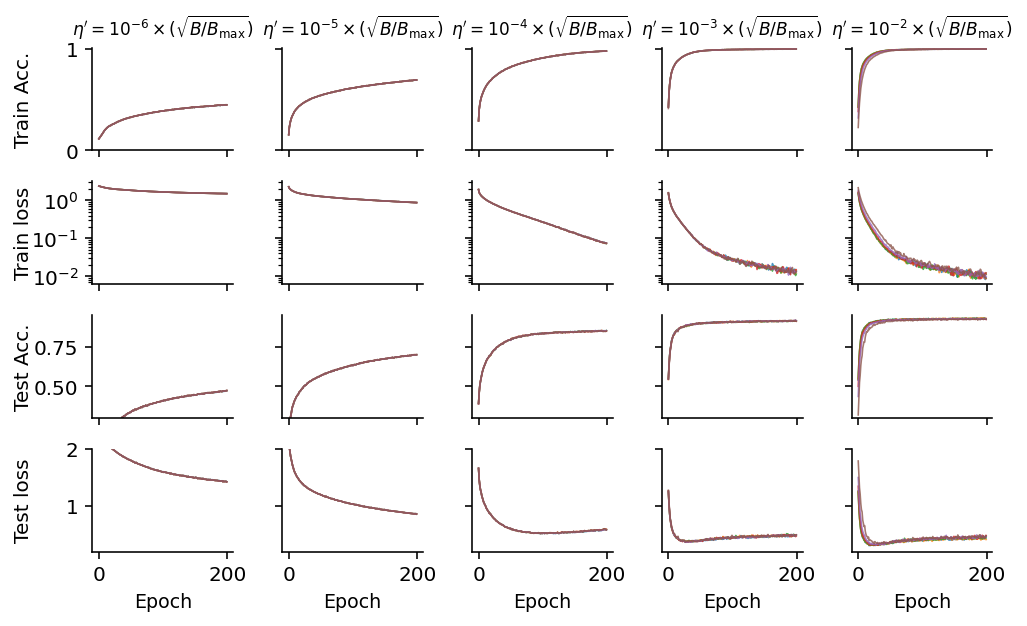

In [21]:

fig, ax = plt.subplots(4, 5, figsize=(6.25, 3.5), sharex='col', sharey='row')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, hspace=0.3, left=left, right=right, bottom=bottom, top=top)
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# lrs_list = [1e-6, 1e-5, 1e-4, 1e-3]
# lrs_list = [1e-6, 1e-5, 1e-3, 1e-1]
for i, lr in enumerate(lrs_list):
    for bs in bs_list:
        R = load_result(lr, 25, bs, seeds=[ 111, 11111], use_bn=True, adamSTD=False)
        ax[0, i].plot(R[0][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[1, i].plot(R[0][..., 1].mean(0), alpha=0.8, linewidth=0.8)
        ax[2, i].plot(R[1][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[3, i].plot(R[1][..., 1].mean(0), alpha=0.8, linewidth=0.8, label=f'$B=$ {bs}',)
    title_str = '$\\eta^\\prime = 10^{{{}}} \\times (\\sqrt{{B / B_{{\\rm max}} }})$'.format(int(np.log10(lr)))
    ax[0, i].set_title(title_str, fontsize=8.5)
    ax[-1, i].set_xlabel("Epoch", fontsize=9.5)

LABEL_SIZE = 10
ax[0, 0].set_ylabel("Train Acc.", fontsize=LABEL_SIZE)
ax[1, 0].set_ylabel("Train loss", fontsize=LABEL_SIZE)
ax[2, 0].set_ylabel("Test Acc.", fontsize=LABEL_SIZE)
ax[3, 0].set_ylabel("Test loss", fontsize=LABEL_SIZE)
ax[0, 0].set_ylim(0.0, 1.01)
# ax[0, 0].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[3, 0].set_ylim(top=2.0)
ax[2, 0].set_ylim(0.3, 0.95)
for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
# ax[1, 0].set_ylim(top=10e2)
for j in range(4):
    ax[j, 0].yaxis.set_label_coords(-0.42, 0.5)
# fig.savefig('./figs/std_adam_batch_norm_trace.pdf', bbox_inches='tight')
# legend = ax[-1, -1].legend(loc='center right', bbox_to_anchor=(0.6, -1.0), ncol=6, fontsize=8)

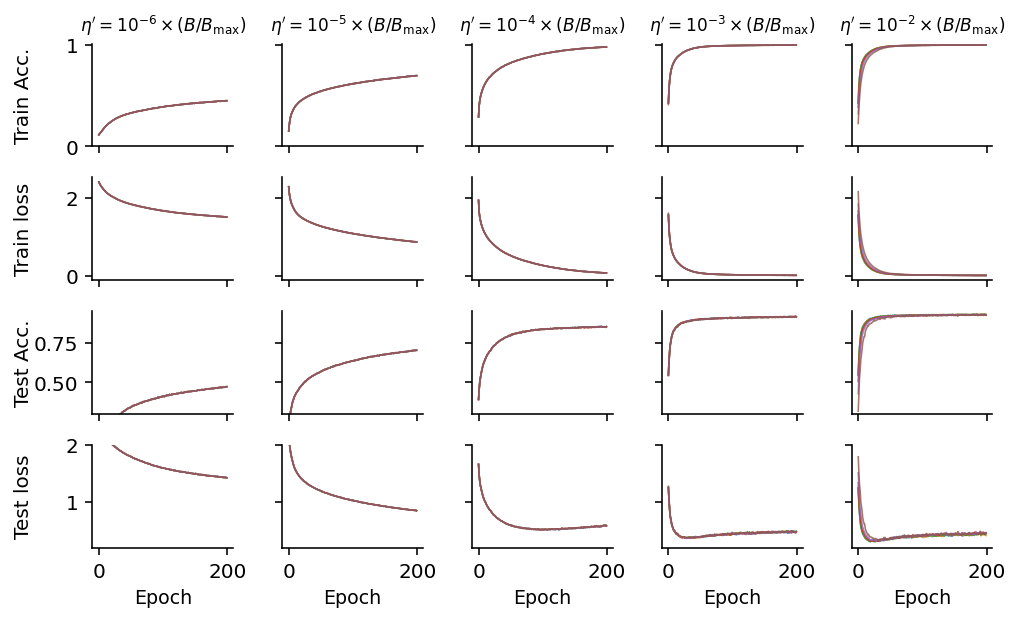

In [14]:
fig, ax = plt.subplots(4, 5, figsize=(6.25, 3.5), sharex='col', sharey='row')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, hspace=0.3, left=left, right=right, bottom=bottom, top=top)

lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# lrs_list = [1e-6, 1e-5, 1e-3, 1e-1]
for i, lr in enumerate(lrs_list):
    for bs in bs_list:
        R = load_result(lr, 25, bs, seeds=[11, 111, 11111], use_bn=True, adamSTD=False)
        ax[0, i].plot(R[0][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[1, i].plot(R[0][..., 1].mean(0), alpha=0.8, linewidth=0.8)
        ax[2, i].plot(R[1][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[3, i].plot(R[1][..., 1].mean(0), alpha=0.8, linewidth=0.8, label=f'$B=$ {bs}',)
    title_str = '$\\eta^\\prime = 10^{{{}}} \\times (B/B_{{\\rm max}})$'.format(int(np.log10(lr)))
    ax[0, i].set_title(title_str, fontsize=8.5)
    ax[-1, i].set_xlabel("Epoch", fontsize=9.5)

LABEL_SIZE = 10
ax[0, 0].set_ylabel("Train Acc.", fontsize=LABEL_SIZE)
ax[1, 0].set_ylabel("Train loss", fontsize=LABEL_SIZE)
ax[2, 0].set_ylabel("Test Acc.", fontsize=LABEL_SIZE)
ax[3, 0].set_ylabel("Test loss", fontsize=LABEL_SIZE)
# ax[1, 0].set_yscale('log')
ax[0, 0].set_ylim(0.0, 1.01)
# ax[0, 0].set_yscale('log')
# ax[1, 0].set_yscale('log')
ax[3, 0].set_ylim(top=2.0)
ax[2, 0].set_ylim(0.3, 0.95)
for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
# ax[1, 0].set_ylim(top=10e2)
for j in range(4):
    ax[j, 0].yaxis.set_label_coords(-0.42, 0.5)
# fig.savefig('./figs/BI_adam_batch_norm_trace.pdf', bbox_inches='tight')
# legend = ax[-1, -1].legend(loc='center right', bbox_to_anchor=(0.6, -1.0), ncol=6, fontsize=8)

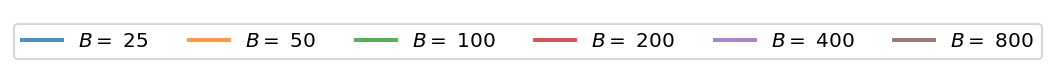

In [101]:
legend1 = ax[-1, -1].legend(ncol=6) # Legend you got from other plots
# Create a new figure just for the legend
fig_leg = plt.figure(figsize=(2, 0.5))  # You can adjust the size as needed
ax_leg = fig_leg.add_subplot(111)

label_order = [0, 1, 2, 3, 4, 5] # If you wanna switch order for the legneds
leg = ax_leg.legend(
    handles=[legend1.legendHandles[i] for i in label_order],
    # You could also manually write the names for the labels
    labels=[legend1.get_texts()[i].get_text() for i in label_order], 
    ncol=6, loc='center'
)

# Adjust the linewidth if you want
for line in leg.get_lines():
    line.set_linewidth(2)

# Turn off the axis
ax_leg.axis("off")
fig_leg.savefig('./figs/bs_legend.pdf', bbox_inches='tight', pad_inches=0.01)

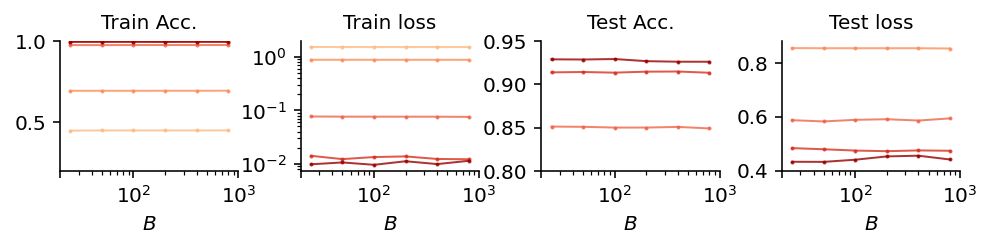

In [102]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -3
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list:

        R = load_result(lr, 25, bs, seeds=[11, 111, 11111], use_bn=True, adamSTD=False)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for j in range(4):
        ax[j].plot(bs_list, metrics[:, j], label=f'eta={lr}', c=colors[i], linewidth=1.0, alpha=0.8, marker='o', markersize=1.0)
ax[1].set_yscale('log')
ax[0].set_ylim(0.2, 1.0)
ax[2].set_ylim(0.8, 0.95)
ax[3].set_ylim(0.4, 0.88)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel(r'$B$')
    a.set_xticks([20, 100, 1000])
fig.savefig('./figs/BI_adam_batch_norm_vs_B.pdf', bbox_inches='tight')

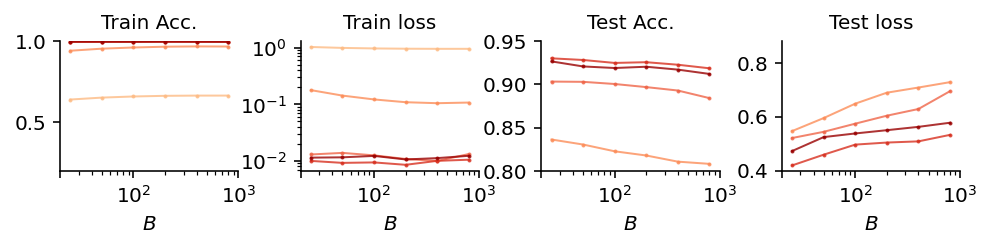

In [103]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -3
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list:

        R = load_result(lr, 25, bs, seeds=[1,  111], use_bn=True, adamSTD=True)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for j in range(4):
        ax[j].plot(bs_list, metrics[:, j], label='$\\eta = 10^{{{}}}$'.format(int(np.log10(lr))),
                   c=colors[i], linewidth=1.0, alpha=0.8, marker='o', markersize=1.0)
ax[1].set_yscale('log')
ax[0].set_ylim(0.2, 1.0)
ax[2].set_ylim(0.8, 0.95)
ax[3].set_ylim(0.4, 0.88)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel(r'$B$')
    a.set_xticks([20, 100, 1000])
fig.savefig('./figs/std_adam_batch_norm_vs_B.pdf', bbox_inches='tight')

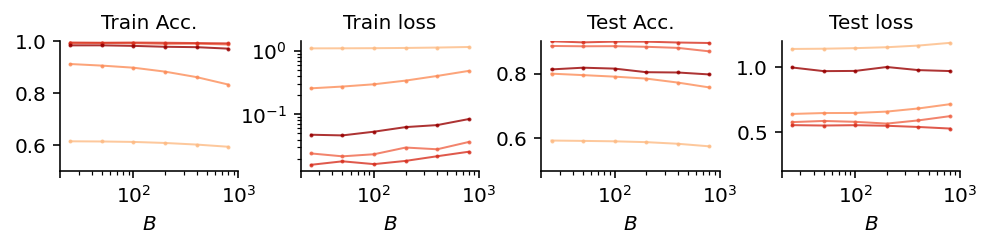

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -5
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list:

        R = load_result(lr, 25, bs, seeds=[1, 111, 11111], use_bn=False, adamSTD=True)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for j in range(4):
        ax[j].plot(bs_list, metrics[:, j], label='$\\eta = 10^{{{}}}$'.format(int(np.log10(lr))),
                   c=colors[i], linewidth=1.0, alpha=0.8, marker='o', markersize=1.0)
ax[1].set_yscale('log')
ax[0].set_ylim(0.5, 1.0)
ax[2].set_ylim(0.5, 0.9)
ax[3].set_ylim(0.2, 1.2)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel(r'$B$')
    a.set_xticks([20, 100, 1000])
fig.savefig('./figs/std_adam_layer_norm_vs_B.pdf', bbox_inches='tight')

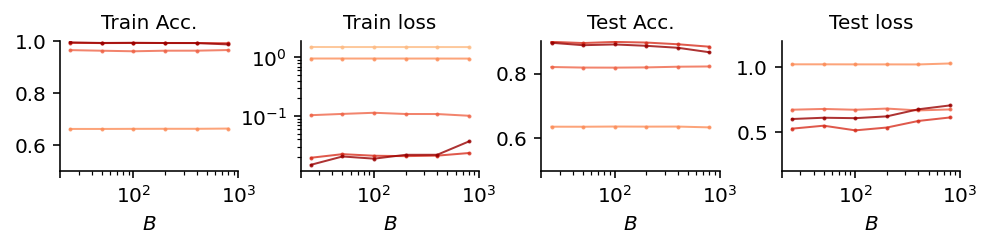

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -5
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list:

        R = load_result(lr, 25, bs, seeds=[1, 111, 11111], use_bn=False, adamSTD=False)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for j in range(4):
        ax[j].plot(bs_list, metrics[:, j], label='$\\eta = 10^{{{}}}$'.format(int(np.log10(lr))),
                   c=colors[i], linewidth=1.0, alpha=0.8, marker='o', markersize=1.0)
ax[1].set_yscale('log')
ax[0].set_ylim(0.5, 1.0)
ax[2].set_ylim(0.5, 0.9)
ax[3].set_ylim(0.2, 1.2)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel(r'$B$')
    a.set_xticks([20, 100, 1000])
fig.savefig('./figs/bi_adam_layer_norm_vs_B.pdf', bbox_inches='tight')

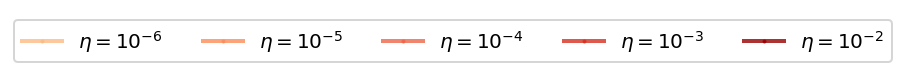

In [110]:
legend1 = ax[-1].legend(ncol=4) # Legend you got from other plots
# Create a new figure just for the legend
fig_leg = plt.figure(figsize=(2, 0.5))  # You can adjust the size as needed
ax_leg = fig_leg.add_subplot(111)

label_order = [0, 1, 2, 3, 4] # If you wanna switch order for the legneds
leg = ax_leg.legend(
    handles=[legend1.legendHandles[i] for i in label_order],
    # You could also manually write the names for the labels
    labels=[legend1.get_texts()[i].get_text() for i in label_order], 
    ncol=5, loc='center'
)

# Adjust the linewidth if you want
for line in leg.get_lines():
    line.set_linewidth(2)

# Turn off the axis
ax_leg.axis("off")
fig_leg.savefig('./figs/eta_legend.pdf', bbox_inches='tight', pad_inches=0.01)

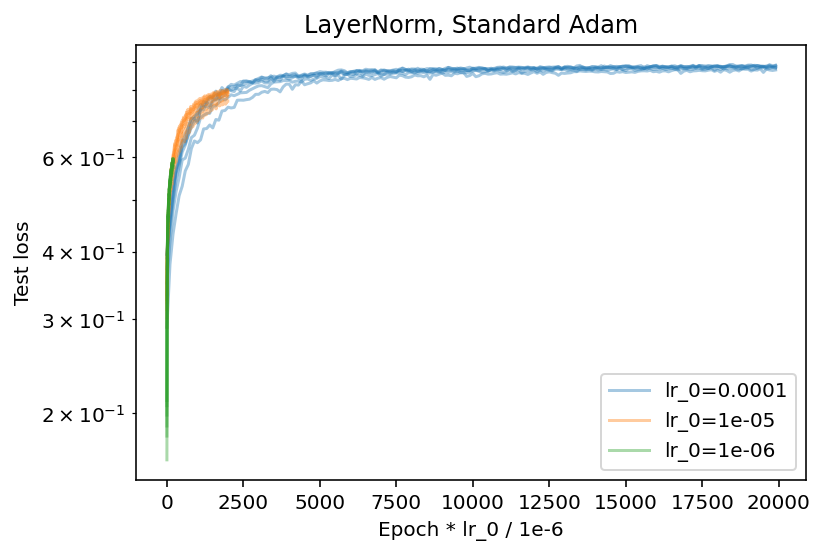

In [88]:
colors = plt.get_cmap('tab10')
for i, lr in enumerate(lrs[:3][::-1]):
    metrics = []
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 25, bs, seeds=[1, 111, 11111], use_bn=False, adamSTD=True)
        X = np.arange(200) * lr / 1e-6
        plt.plot(X, R[1][:,:, 0].mean((0,)), c=colors([i]), alpha=0.4, label=f'lr_0={lr}' if not j else '')
    # metrics = np.array(metrics)
    # X = np.arange(200)
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Test loss')
plt.xlabel('Epoch * lr_0 / 1e-6')
plt.title('LayerNorm, Standard Adam')
plt.legend()

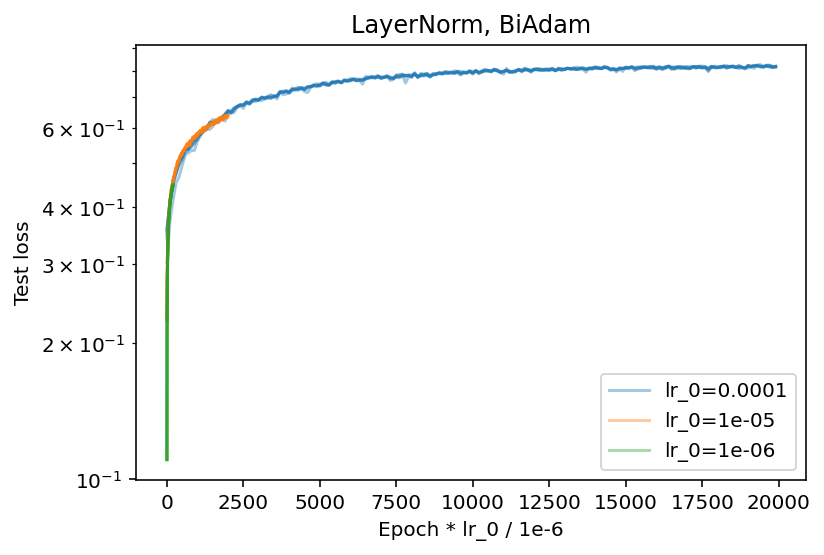

In [87]:
colors = plt.get_cmap('tab10')
for i, lr in enumerate(lrs[:3][::-1]):
    metrics = []
    for j, bs in enumerate(bs_list):
        R = load_result(lr, 25, bs, seeds=[1, 111, 11111], use_bn=False, adamSTD=False)
        X = np.arange(200) * lr / 1e-6
        plt.plot(X, R[1][:,:, 0].mean((0,)), c=colors([i]), alpha=0.4, label=f'lr_0={lr}' if not j else '')
    # metrics = np.array(metrics)
    # X = np.arange(200)
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Test loss')
plt.xlabel('Epoch * lr_0 / 1e-6')
plt.title('LayerNorm, BiAdam')
plt.legend()

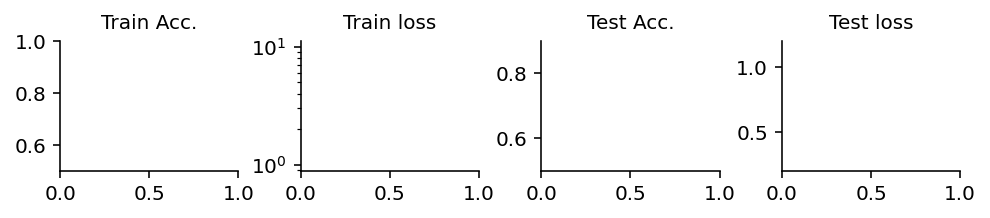

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, left=left, right=right, bottom=bottom, top=top)

colors = ['#fef0d9','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'][-5:]
# lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
bs_list = [25, 50, 100, 200, 400, 800]
N = -100
for i, lr in enumerate(lrs):
    metrics = []
    for bs in bs_list:
        R = load_result(lr, 25, bs, seeds=[1, 111, 11111], use_bn=False, adamSTD=False)
        metrics.append(
            (
                R[0][:,:, 0].mean((0,)),
                R[0][:,:, 1].mean((0,)),
                R[1][:,:, 0].mean((0,)),
                R[1][:,:, 1].mean((0,))
            )
        )
    metrics = np.array(metrics)
    X = np.arange(200)
    # plt.plot

ax[1].set_yscale('log')
ax[0].set_ylim(0.5, 1.0)
ax[2].set_ylim(0.5, 0.9)
ax[3].set_ylim(0.2, 1.2)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

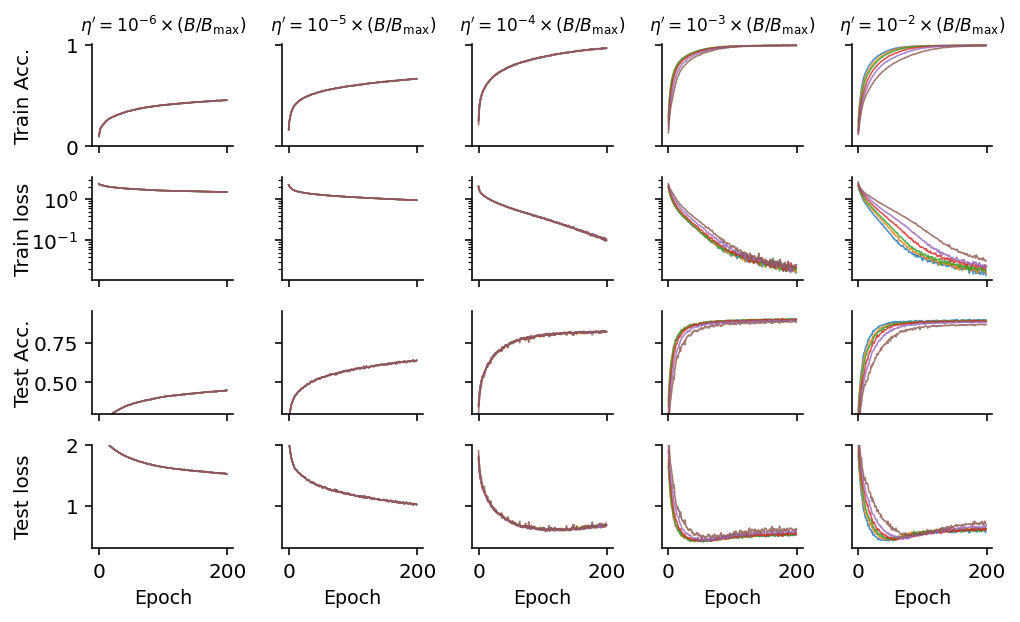

In [66]:
fig, ax = plt.subplots(4, 5, figsize=(6.25, 3.5), sharex='col', sharey='row')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, hspace=0.3, left=left, right=right, bottom=bottom, top=top)
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# lrs_list = [1e-6, 1e-5, 1e-4, 1e-3]
# lrs_list = [1e-6, 1e-5, 1e-3, 1e-1]
for i, lr in enumerate(lrs_list):
    for bs in bs_list:
        R = load_result(lr, 25, bs, seeds=[1,  111, 11111], use_bn=False, adamSTD=False)
        ax[0, i].plot(R[0][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[1, i].plot(R[0][..., 1].mean(0), alpha=0.8, linewidth=0.8)
        ax[2, i].plot(R[1][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[3, i].plot(R[1][..., 1].mean(0), alpha=0.8, linewidth=0.8, label=f'$B=$ {bs}',)
    title_str = '$\\eta^\\prime = 10^{{{}}} \\times (B / B_{{\\rm max}}) $'.format(int(np.log10(lr)))
    ax[0, i].set_title(title_str, fontsize=8.5)
    ax[-1, i].set_xlabel("Epoch", fontsize=9.5)

LABEL_SIZE = 10
ax[0, 0].set_ylabel("Train Acc.", fontsize=LABEL_SIZE)
ax[1, 0].set_ylabel("Train loss", fontsize=LABEL_SIZE)
ax[2, 0].set_ylabel("Test Acc.", fontsize=LABEL_SIZE)
ax[3, 0].set_ylabel("Test loss", fontsize=LABEL_SIZE)
ax[0, 0].set_ylim(0.0, 1.01)
# ax[0, 0].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[3, 0].set_ylim(top=2.0)
ax[2, 0].set_ylim(0.3, 0.95)
for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
# ax[1, 0].set_ylim(top=10e2)
for j in range(4):
    ax[j, 0].yaxis.set_label_coords(-0.42, 0.5)
fig.savefig('./figs/bi_adam_layer_norm_trace.pdf', bbox_inches='tight')
# legend = ax[-1, -1].legend(loc='center right', bbox_to_anchor=(0.6, -1.0), ncol=6, fontsize=8)

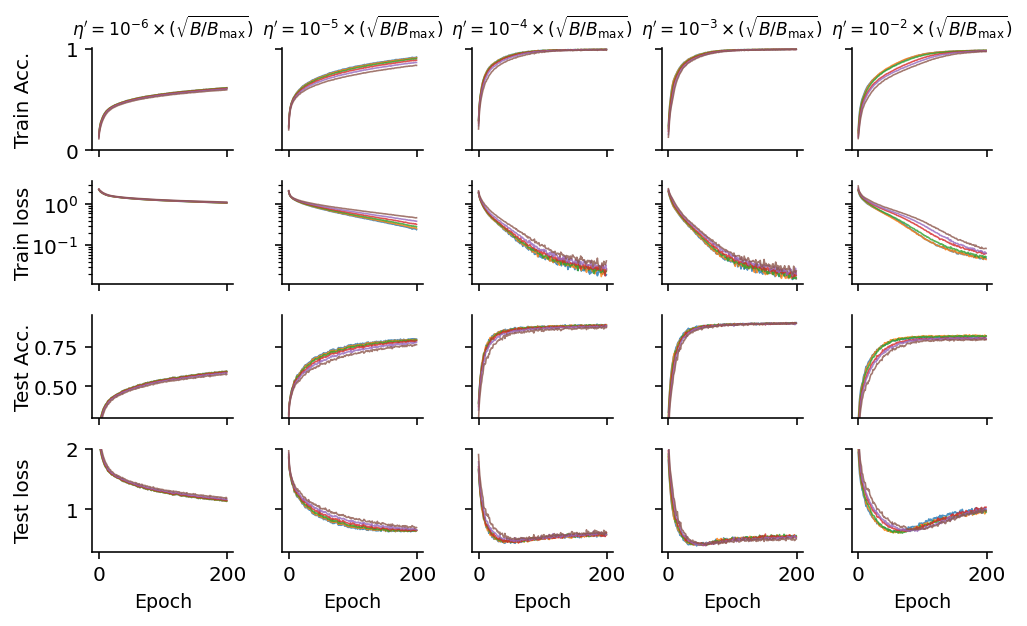

In [55]:
fig, ax = plt.subplots(4, 5, figsize=(6.25, 3.5), sharex='col', sharey='row')
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.35, hspace=0.3, left=left, right=right, bottom=bottom, top=top)
lrs_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# lrs_list = [1e-6, 1e-5, 1e-4, 1e-3]
# lrs_list = [1e-6, 1e-5, 1e-3, 1e-1]
for i, lr in enumerate(lrs_list):
    for bs in bs_list:
        R = load_result(lr, 25, bs, seeds=[1,  111, 11111], use_bn=False, adamSTD=True)
        ax[0, i].plot(R[0][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[1, i].plot(R[0][..., 1].mean(0), alpha=0.8, linewidth=0.8)
        ax[2, i].plot(R[1][..., 0].mean(0), alpha=0.8, linewidth=0.8)
        ax[3, i].plot(R[1][..., 1].mean(0), alpha=0.8, linewidth=0.8, label=f'$B=$ {bs}',)
    title_str = '$\\eta^\\prime = 10^{{{}}} \\times (\\sqrt{{B / B_{{\\rm max}} }})$'.format(int(np.log10(lr)))
    ax[0, i].set_title(title_str, fontsize=8.5)
    ax[-1, i].set_xlabel("Epoch", fontsize=9.5)

LABEL_SIZE = 10
ax[0, 0].set_ylabel("Train Acc.", fontsize=LABEL_SIZE)
ax[1, 0].set_ylabel("Train loss", fontsize=LABEL_SIZE)
ax[2, 0].set_ylabel("Test Acc.", fontsize=LABEL_SIZE)
ax[3, 0].set_ylabel("Test loss", fontsize=LABEL_SIZE)
ax[0, 0].set_ylim(0.0, 1.01)
# ax[0, 0].set_yscale('log')
ax[1, 0].set_yscale('log')
ax[3, 0].set_ylim(top=2.0)
ax[2, 0].set_ylim(0.3, 0.95)
for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
# ax[1, 0].set_ylim(top=10e2)
for j in range(4):
    ax[j, 0].yaxis.set_label_coords(-0.42, 0.5)
fig.savefig('./figs/std_adam_layer_norm_trace.pdf', bbox_inches='tight')
# legend = ax[-1, -1].legend(loc='center right', bbox_to_anchor=(0.6, -1.0), ncol=6, fontsize=8)

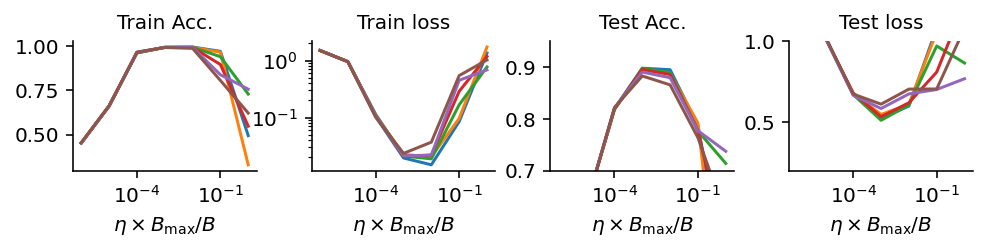

In [229]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.3, left=left, right=right, bottom=bottom, top=top)

lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
bs_list = [25, 50, 100, 200, 400, 800]
N = -5
for bs in bs_list:
    metrics = []
    for i, lr in enumerate(lrs):
        R = load_result(lr, 25, bs, seeds=[1, 111, 11111], use_bn=False)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for i in range(4):
        ax[i].plot(lrs, metrics[:, i])
ax[1].set_yscale('log')
ax[2].set_ylim(0.7, 0.95)
ax[3].set_ylim(0.2, 1.0)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('$\eta \\times B_{{\\rm max}} / B$')
# fig.savefig('./figs/BI_adam_batch_norm_metric_lr.pdf', bbox_inches='tight')

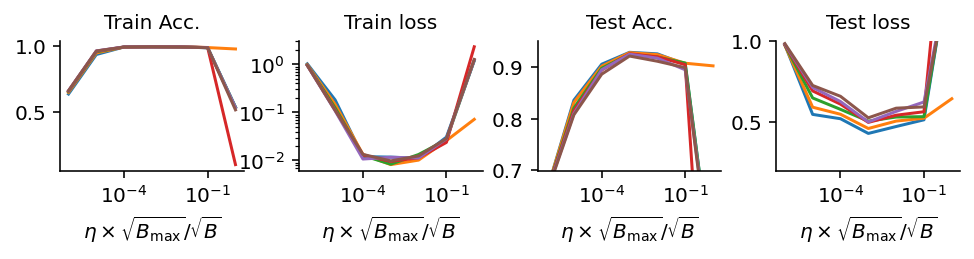

In [186]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.9))
bottom = 0.0
top = 1.0
left = 0.0
right = 1.0
fig.subplots_adjust(wspace=0.3, left=left, right=right, bottom=bottom, top=top)

lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
bs_list = [25, 50, 100, 200, 400, 800]
N = -5
for bs in bs_list:
    metrics = []
    for i, lr in enumerate(lrs):
        R = load_result(lr, 25, bs, seeds=[1, 111], use_bn=True, adamSTD=True)
        metrics.append(
            (
                R[0][:,N-1:N+1, 0].mean((0, 1)),
                R[0][:,N-1:N+1, 1].mean((0, 1)),
                R[1][:,N-1:N+1, 0].mean((0, 1)),
                R[1][:,N-1:N+1, 1].mean((0, 1))
            )
        )
    metrics = np.array(metrics)
    for i in range(4):
        ax[i].plot(lrs, metrics[:, i])
ax[1].set_yscale('log')
ax[2].set_ylim(0.7, 0.95)
ax[3].set_ylim(0.2, 1.0)
TITEL_SIZE = 10
ax[0].set_title("Train Acc.", fontsize=TITEL_SIZE)
ax[1].set_title("Train loss", fontsize=TITEL_SIZE)
ax[2].set_title("Test Acc.", fontsize=TITEL_SIZE)
ax[3].set_title("Test loss", fontsize=TITEL_SIZE)
for a in ax:
    a.set_xscale('log')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('$\eta \\times \\sqrt{{B_{{\\rm max}}}} / \\sqrt{{B}}$')
# fig.savefig('./figs/BI_adam_batch_norm_metric_lr.pdf', bbox_inches='tight')

Text(0, 0.5, 'Time per epoch (s)')

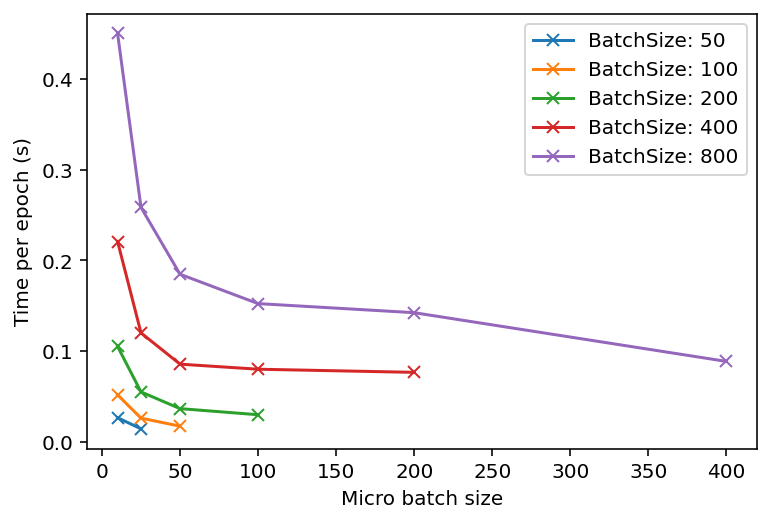

In [5]:
mbs_list = [10, 25, 50, 100, 200, 400, 800]
bs_list = [50, 100, 200, 400, 800]
for i, bs in enumerate(bs_list):
    all_time = []
    for mbs in mbs_list[:(i + 2)]:
        all_time.append(np.mean(np.load(f'./results/time_{mbs}_{bs}.npy')))
    plt.plot(mbs_list[:(i + 2)], all_time, marker='x', label=f'BatchSize: {bs}')
plt.legend()

# bs = 800
# all_time = []
# for mbs in mbs_list:
#     all_time.append(np.mean(np.load(f'./results/time_{mbs}_{bs}.npy')))
# plt.plot(mbs_list, all_time, marker='x')

# mbs_list = [10, 25, 50, 100, 200, 400]
# bs = 400
# all_time = []
# for mbs in mbs_list:
#     all_time.append(np.mean(np.load(f'./results/time_{mbs}_{bs}.npy')))
# plt.plot(mbs_list, all_time, marker='x')

# mbs_list = [10, 25, 50, 100, 200]
# bs = 200
# all_time = []
# for mbs in mbs_list:
#     all_time.append(np.mean(np.load(f'./results/time_{mbs}_{bs}.npy')))
# plt.plot(mbs_list, all_time, marker='x')

# mbs_list = [10, 25, 50, 100]
# bs = 100
# all_time = []
# for mbs in mbs_list:
#     all_time.append(np.mean(np.load(f'./results/time_{mbs}_{bs}.npy')))
# plt.plot(mbs_list, all_time, marker='x')

# mbs_list = [10, 25, 50]
# bs = 50
# all_time = []
# for mbs in mbs_list:
#     all_time.append(np.mean(np.load(f'./results/time_{mbs}_{bs}.npy')))
# plt.plot(mbs_list, all_time, marker='x')

# plt.xscale('log')
plt.xlabel('Micro batch size')
plt.ylabel('Time per epoch (s)')